In [4]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [4]:
from datasets import load_dataset
ds = load_dataset("glue", "sst2")
print(ds)
# ds["train"][0] -> {'sentence': '...', 'label': 0 or 1}

KeyboardInterrupt: 

In [2]:

import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    TFAutoModelForSequenceClassification,
    create_optimizer
)

# Set Hugging Face endpoint before loading dataset
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# Load SST-2 dataset
ds = load_dataset("glue", "sst2")
raw_train_dataset = ds['train']
raw_test_dataset = ds['validation']  # SST-2 uses 'validation' split for testing
print(raw_train_dataset.shape)
print(raw_test_dataset.shape)
def set_seed(seed):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

base_seed = 42
num_epochs = 2
num_runs_per_trial = 1
num_trials = 1
batch_size = 16

all_runs_results, all_histories, cv_train_list, cv_test_list = [], [], [], []

# GPU setup
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_type = "CPU"
if gpu_devices:
    gpu_type = "_".join([dev.name.split(':')[-1] for dev in gpu_devices])
    print(f"Using GPU(s): {gpu_type}")
    # Configure GPU memory growth
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

# Use DistilRoBERTa tokenizer (consistent naming)
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
max_length = 256

# Extract text and labels as lists
train_texts = list(raw_train_dataset['sentence'])
train_labels = list(raw_train_dataset['label'])
test_texts = list(raw_test_dataset['sentence'])
test_labels = list(raw_test_dataset['label'])

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Sample training text: {train_texts[0]}")
print(f"Sample training label: {train_labels[0]}")

# Tokenize datasets
train_encodings = tokenizer(
    train_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)
test_encodings = tokenizer(
    test_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for trial_idx in range(num_trials):
    print(f"\n======= Trial {trial_idx+1}/{num_trials} =======")
    trial_train_accuracies, trial_test_accuracies = [], []

    for run_idx in range(num_runs_per_trial):
        current_seed = base_seed + trial_idx * 1000 + run_idx
        print(f"\n--- Trial {trial_idx+1}, Run {run_idx+1}/{num_runs_per_trial} | seed={current_seed} ---")
        set_seed(current_seed)

        # Load DistilRoBERTa model for sequence classification
        model = TFAutoModelForSequenceClassification.from_pretrained(
            "distilroberta-base", 
            num_labels=2
        )
        
        print("Model summary:")
        print(f"Model parameters: {model.num_parameters():,}")

        # Calculate training steps
        num_training_steps = len(train_texts) // batch_size * num_epochs
        
        # Create optimizer with warmup
        optimizer, schedule = create_optimizer(
            init_lr=5e-6,
            num_train_steps=num_training_steps,
            num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
            weight_decay_rate=0.01
        )

        # Compile model
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy']
        )

        # Training callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        history = model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=1
        )

        # Get final metrics
        final_train_acc = history.history["accuracy"][-1]
        final_val_acc = history.history["val_accuracy"][-1]
        final_train_loss = history.history["loss"][-1]
        final_val_loss = history.history["val_loss"][-1]
        
        print(f"Run {run_idx+1} Final -> Train Acc: {final_train_acc*100:.2f}%, Test Acc: {final_val_acc*100:.2f}%")
        
        all_runs_results.append((
            final_train_loss, final_train_acc, final_val_loss, final_val_acc,
            run_idx+1, trial_idx+1
        ))
        
        trial_train_accuracies.append(final_train_acc)
        trial_test_accuracies.append(final_val_acc)
        
        # Store history
        epochs_trained = len(history.history["accuracy"])
        run_history_df = pd.DataFrame(history.history)
        run_history_df["epoch"] = np.arange(1, epochs_trained + 1)
        run_history_df["run"] = run_idx + 1
        run_history_df["trial"] = trial_idx + 1
        all_histories.append(run_history_df)
    
    # Compute CV for the trial
    train_acc_arr, test_acc_arr = np.array(trial_train_accuracies), np.array(trial_test_accuracies)
    mean_train_acc, std_train_acc = train_acc_arr.mean(), train_acc_arr.std()
    cv_train = std_train_acc / mean_train_acc if mean_train_acc != 0 else 0.0
    mean_test_acc, std_test_acc = test_acc_arr.mean(), test_acc_arr.std()
    cv_test = std_test_acc / mean_test_acc if mean_test_acc != 0 else 0.0
    
    print(f"\n*** Trial {trial_idx+1} Stats ***")
    print(f"Train Acc (Mean, Std, CV): {mean_train_acc:.4f}, {std_train_acc:.4f}, {cv_train:.4f}")
    print(f"Test  Acc (Mean, Std, CV): {mean_test_acc:.4f}, {std_test_acc:.4f}, {cv_test:.4f}")
    
    cv_train_list.append(cv_train)
    cv_test_list.append(cv_test)

# Final Analysis
if cv_train_list and cv_test_list:
    mean_cv_train, mean_cv_test = np.mean(cv_train_list), np.mean(cv_test_list)
    gpu_reproducibility, whole_reproducibility = 1.0 - mean_cv_train, 1.0 - mean_cv_test
    print("\n============================")
    print("Final Reproducibility Stats")
    print("============================")
    print(f"Mean CV (Train): {mean_cv_train:.6f} => GPU Reproducibility   = {gpu_reproducibility:.6f}")
    print(f"Mean CV (Test) : {mean_cv_test:.6f} => Whole Reproducibility = {whole_reproducibility:.6f}")

# Save results
if all_runs_results:
    output_dir = f"results_sst2_distilroberta_TF_{time.strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(output_dir, exist_ok=True)
    
    columns = ["train_loss", "train_accuracy", "test_loss", "test_accuracy", "run", "trial"]
    all_runs_df = pd.DataFrame(all_runs_results, columns=columns)
    results_path = os.path.join(output_dir, f"sst2_GPU_{gpu_type}_all_runs_results.csv")
    all_runs_df.to_csv(results_path, index=False)
    print(f"\nPer-run final metrics saved to: {results_path}")

if all_histories:
    all_histories_df = pd.concat(all_histories, ignore_index=True)
    history_path = os.path.join(output_dir, "training_history.csv")
    all_histories_df.to_csv(history_path, index=False)
    print(f"Detailed epoch-by-epoch history saved to: {history_path}")

    # Generate and Save Plots
    unique_trials = sorted(all_histories_df["trial"].unique())
    for t in unique_trials:
        trial_history = all_histories_df[all_histories_df["trial"] == t]
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), squeeze=False)
        axes = axes.ravel()
        
        for run_id in sorted(trial_history["run"].unique()):
            run_data = trial_history[trial_history["run"] == run_id]
            axes[0].plot(run_data["epoch"], run_data["loss"], marker='o', linestyle='-', 
                        label=f"Train Loss (Run {run_id})")
            axes[0].plot(run_data["epoch"], run_data["val_loss"], marker='s', linestyle='--', 
                        label=f"Val Loss (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["accuracy"], marker='o', linestyle='-', 
                        label=f"Train Acc (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["val_accuracy"], marker='s', linestyle='--', 
                        label=f"Val Acc (Run {run_id})")
        
        # Configure plots
        max_epochs = trial_history["epoch"].max()
        axes[0].set_title(f"Trial {t} - Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True)
        axes[0].legend()
        axes[0].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        axes[1].set_title(f"Trial {t} - Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        plt.suptitle(f"Metrics for Trial {t}", fontsize=16, y=1.02)
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"metrics_curves_trial_{t}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Training/Validation metrics for Trial {t} saved to: {plot_path}")

print("\nTraining completed successfully!")


2025-08-21 12:35:01.044421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 12:35:01.057556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755750901.072514    1221 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755750901.076915    1221 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755750901.088157    1221 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

(67349, 3)
(872, 3)
Using GPU(s): 0


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Training samples: 67349
Test samples: 872
Sample training text: hide new secretions from the parental units 
Sample training label: 0


I0000 00:00:1755750918.591304    1221 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30459 MB memory:  -> device: 0, name: NVIDIA vGPU-32GB, pci bus id: 0000:c9:00.0, compute capability: 8.9
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



======= Trial 1/1 =======

--- Trial 1, Run 1/1 | seed=42 ---


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model summary:
Model parameters: 82,119,938
Starting training...
Epoch 1/2
  69/4210 [..............................] - ETA: 6:05 - loss: 0.7032 - accuracy: 0.4719

KeyboardInterrupt: 

✓ sklearn available - t-SNE visualization enabled
Training set shape: (67349, 3)
Test set shape: (872, 3)
Using GPU(s): 0
Training samples: 67349
Test samples: 872
Sample training text: hide new secretions from the parental units 
Sample training label: 0

GENERATING PRE-TRAINING t-SNE VISUALIZATIONS
Using TRAINING SET for visualization: 67349 total samples
Will sample up to 10000 samples for t-SNE visualization

--- Creating TF-IDF Embeddings from Training Set (sampled from 67349 total) ---
Creating TF-IDF embeddings from 67349 texts (max: 10000)...
Original label distribution: {np.int64(0): np.int64(29780), np.int64(1): np.int64(37569)}
Sampled label distribution: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000)} (Total: 10000)
TF-IDF matrix shape: (10000, 5000)
Applied PCA: 5000 -> 100 dimensions

--- Extracting Pre-trained DistilRoBERTa Embeddings from Training Set (sampled from 67349 total) ---
Extracting pre-trained DistilRoBERTa embeddings from 67349 texts (max: 10000).

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed batch 1/313
Processed batch 2/313
Processed batch 3/313
Processed batch 4/313
Processed batch 5/313
Processed batch 6/313
Processed batch 7/313
Processed batch 8/313
Processed batch 9/313
Processed batch 10/313
Processed batch 11/313
Processed batch 12/313
Processed batch 13/313
Processed batch 14/313
Processed batch 15/313
Processed batch 16/313
Processed batch 17/313
Processed batch 18/313
Processed batch 19/313
Processed batch 20/313
Processed batch 21/313
Processed batch 22/313
Processed batch 23/313
Processed batch 24/313
Processed batch 25/313
Processed batch 26/313
Processed batch 27/313
Processed batch 28/313
Processed batch 29/313
Processed batch 30/313
Processed batch 31/313
Processed batch 32/313
Processed batch 33/313
Processed batch 34/313
Processed batch 35/313
Processed batch 36/313
Processed batch 37/313
Processed batch 38/313
Processed batch 39/313
Processed batch 40/313
Processed batch 41/313
Processed batch 42/313
Processed batch 43/313
Processed batch 44/3

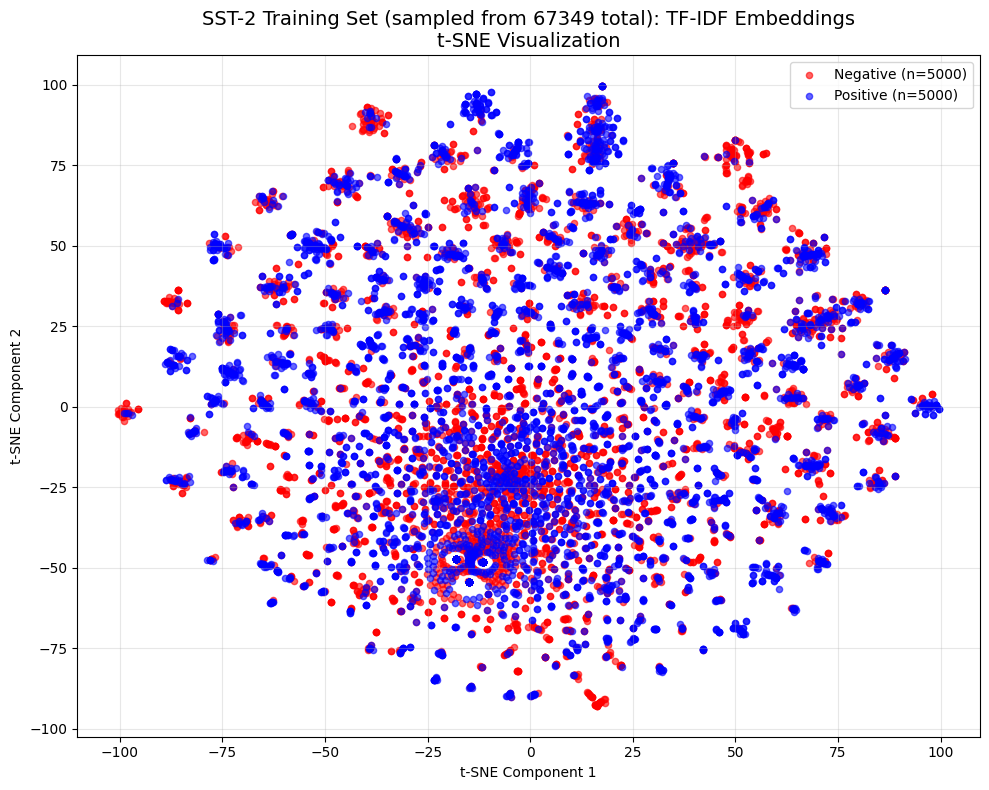

t-SNE plot saved to: results_sst2_distilroberta_TF_20250821_124022/tsne_tfidf_pretraining_train.png
Computing t-SNE for SST-2 Training Set (sampled from 67349 total): Pre-trained DistilRoBERTa (perplexity=30)...


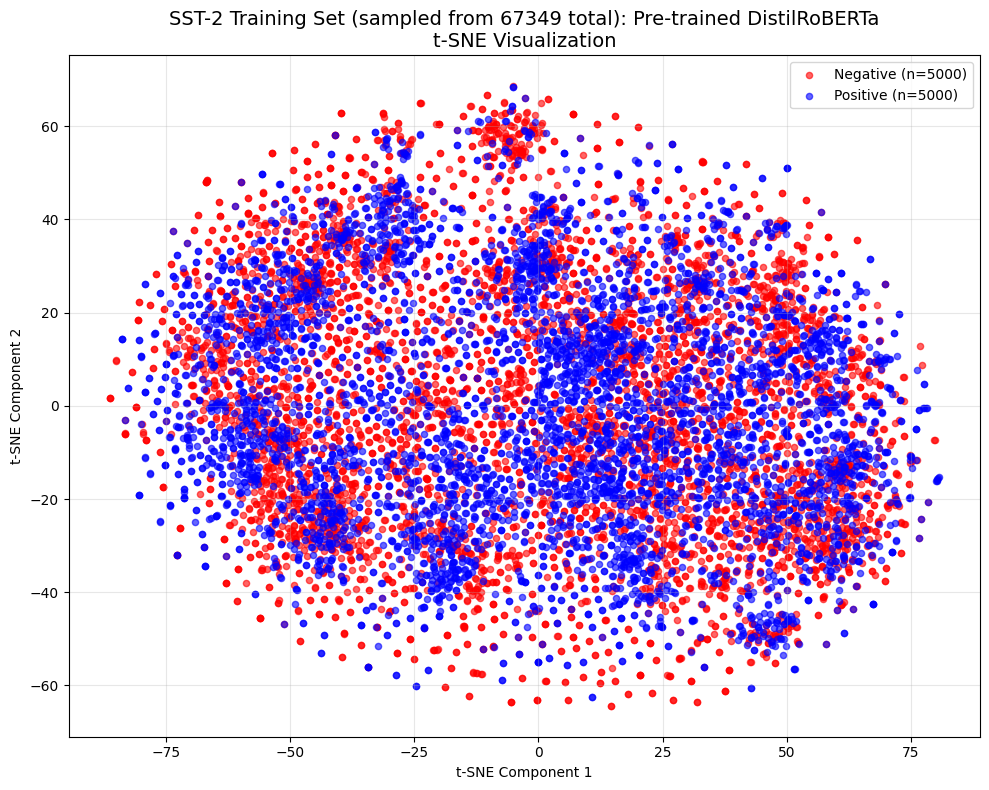

t-SNE plot saved to: results_sst2_distilroberta_TF_20250821_124022/tsne_pretrained_distilroberta_train.png
Computing t-SNE for TF-IDF embeddings (perplexity=30)...
Computing t-SNE for pre-trained DistilRoBERTa embeddings (perplexity=30)...


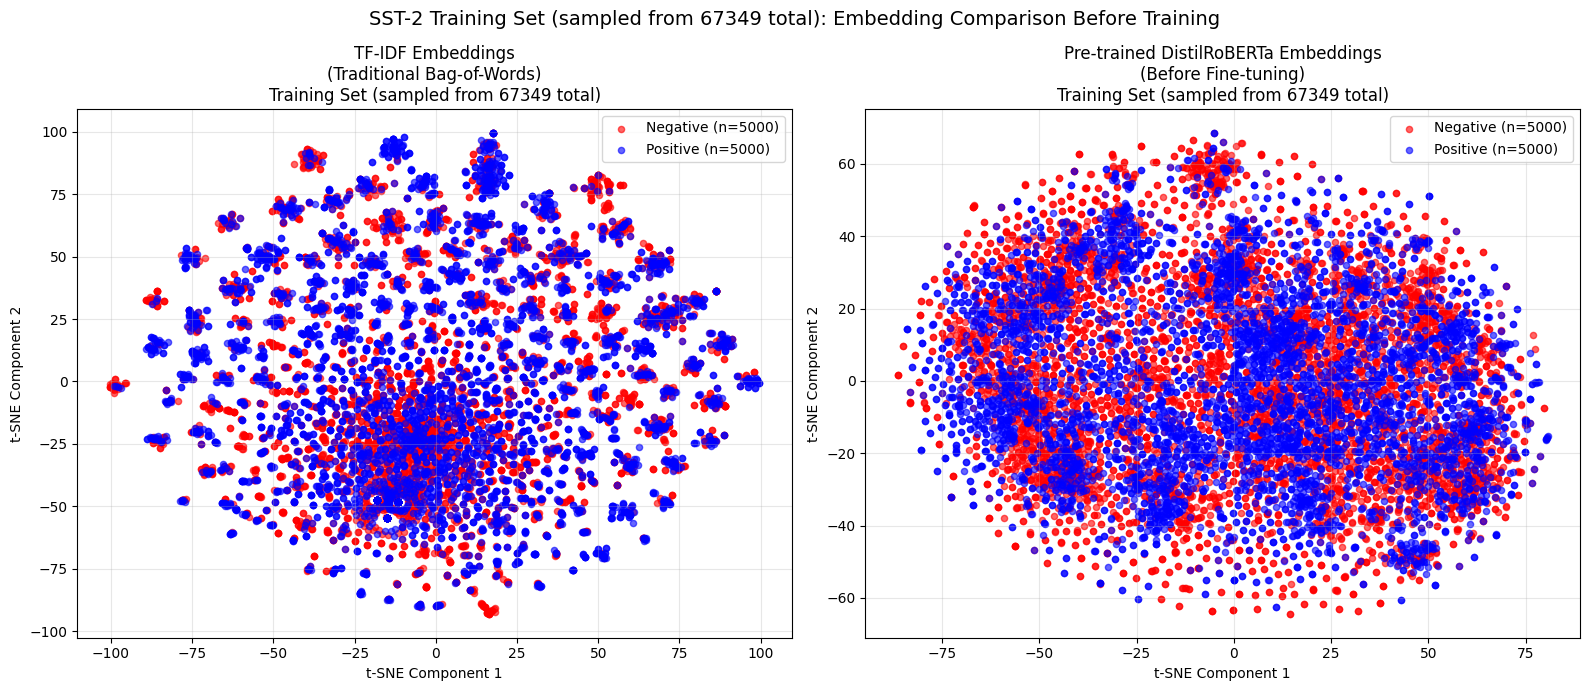

Pre-training t-SNE comparison plot saved to: results_sst2_distilroberta_TF_20250821_124022/tsne_comparison_pretraining_train.png
Computing t-SNE for TF-IDF embeddings (perplexity=50)...
Computing t-SNE for pre-trained DistilRoBERTa embeddings (perplexity=50)...


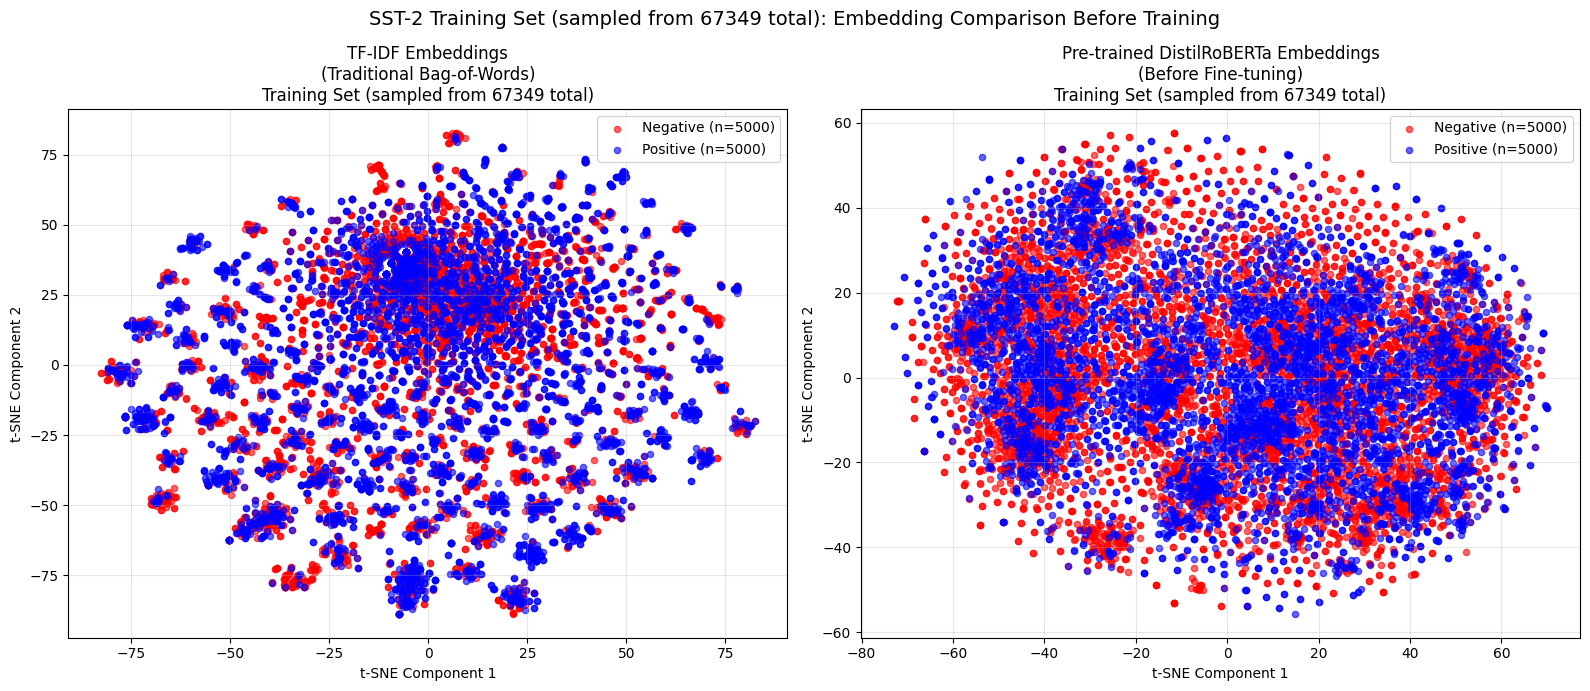

Pre-training t-SNE comparison plot saved to: results_sst2_distilroberta_TF_20250821_124022/tsne_comparison_pretraining_train_perp50.png

✓ Pre-training t-SNE visualizations completed!
✓ Used Training Set (sampled from 67349 total)
✓ Visualizations saved in: results_sst2_distilroberta_TF_20250821_124022

STARTING MODEL TRAINING

======= Trial 1/1 =======

--- Trial 1, Run 1/1 | seed=42 ---


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model summary:
Model parameters: 82,119,938
Starting training...
Epoch 1/2
 978/4210 [=====>........................] - ETA: 4:46 - loss: 0.4835 - accuracy: 0.7193

In [ ]:

import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Handle sklearn import gracefully at the very beginning
SKLEARN_AVAILABLE = False
TSNE = None
TfidfVectorizer = None
PCA = None
'''
try:
    from sklearn.manifold import TSNE
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import PCA
    SKLEARN_AVAILABLE = True
    print("✓ sklearn available - t-SNE visualization enabled")
except ImportError:
    print("⚠ sklearn not available. Attempting to install...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
        from sklearn.manifold import TSNE
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import PCA
        SKLEARN_AVAILABLE = True
        print("✓ sklearn installed and imported successfully")
    except Exception as e:
        print(f"✗ Could not install sklearn: {e}")
        print("Continuing without t-SNE visualization...")
        SKLEARN_AVAILABLE = False
'''
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    TFAutoModelForSequenceClassification,
    create_optimizer
)

# Set Hugging Face endpoint before loading dataset
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# Load SST-2 dataset
ds = load_dataset("glue", "sst2")
raw_train_dataset = ds['train']
raw_test_dataset = ds['validation']  # SST-2 uses 'validation' split for testing
print(f"Training set shape: {raw_train_dataset.shape}")
print(f"Test set shape: {raw_test_dataset.shape}")

def set_seed(seed):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def create_tsne_with_version_compatibility(n_components=2, random_state=42, perplexity=100, learning_rate=200):
    """Create t-SNE object with version compatibility for parameter names"""
    try:
        # Try newer parameter name first (max_iter)
        return TSNE(n_components=n_components, random_state=random_state, 
                   perplexity=perplexity, max_iter=1000, learning_rate=learning_rate)
    except TypeError:
        try:
            # Fall back to older parameter name (n_iter)
            return TSNE(n_components=n_components, random_state=random_state, 
                       perplexity=perplexity, n_iter=1000, learning_rate=learning_rate)
        except TypeError:
            # Minimal parameters if both fail
            return TSNE(n_components=n_components, random_state=random_state, 
                       perplexity=perplexity)

def sample_balanced_data(texts, labels, max_samples, random_state=42):
    """Sample data while maintaining class balance"""
    texts = np.array(texts)
    labels = np.array(labels)
    
    # Get unique labels and their counts
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    print(f"Original label distribution: {dict(zip(unique_labels, label_counts))}")
    
    # Calculate samples per class
    samples_per_class = max_samples // len(unique_labels)
    
    sampled_indices = []
    np.random.seed(random_state)
    
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        if len(label_indices) > samples_per_class:
            # Sample without replacement
            selected_indices = np.random.choice(label_indices, samples_per_class, replace=False)
        else:
            # Use all available samples
            selected_indices = label_indices
        sampled_indices.extend(selected_indices)
    
    sampled_indices = np.array(sampled_indices)
    np.random.shuffle(sampled_indices)  # Shuffle the final indices
    
    sampled_texts = texts[sampled_indices].tolist()
    sampled_labels = labels[sampled_indices]
    
    # Check final distribution
    unique_sampled, sampled_counts = np.unique(sampled_labels, return_counts=True)
    print(f"Sampled label distribution: {dict(zip(unique_sampled, sampled_counts))} (Total: {len(sampled_labels)})")
    
    return sampled_texts, sampled_labels.tolist()

def create_tfidf_embeddings(texts, labels, max_samples=2000, random_state=42):
    """Create TF-IDF embeddings for comparison"""
    if not SKLEARN_AVAILABLE:
        print("sklearn not available - skipping TF-IDF embeddings")
        return None, None
    
    print(f"Creating TF-IDF embeddings from {len(texts)} texts (max: {max_samples})...")
    
    # Sample data if needed
    if len(texts) > max_samples:
        texts, labels = sample_balanced_data(texts, labels, max_samples, random_state)
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=5000,  # Limit features for t-SNE efficiency
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Minimum document frequency
        max_df=0.95  # Maximum document frequency
    )
    
    # Fit and transform texts
    tfidf_matrix = vectorizer.fit_transform(texts)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    
    # Convert to dense array for t-SNE
    tfidf_embeddings = tfidf_matrix.toarray()
    
    # Optional: Apply PCA for dimensionality reduction before t-SNE
    if tfidf_embeddings.shape[1] > 100:
        pca = PCA(n_components=100, random_state=42)
        tfidf_embeddings = pca.fit_transform(tfidf_embeddings)
        print(f"Applied PCA: {tfidf_matrix.shape[1]} -> {tfidf_embeddings.shape[1]} dimensions")
    
    return tfidf_embeddings, np.array(labels)

def extract_pretrained_embeddings(texts, labels, tokenizer, max_samples=2000, random_state=42):
    """Extract embeddings from pre-trained DistilRoBERTa (before fine-tuning)"""
    if not SKLEARN_AVAILABLE:
        return None, None
        
    print(f"Extracting pre-trained DistilRoBERTa embeddings from {len(texts)} texts (max: {max_samples})...")
    
    # Sample data if needed
    if len(texts) > max_samples:
        texts, labels = sample_balanced_data(texts, labels, max_samples, random_state)
    
    # Load pre-trained model (not fine-tuned)
    pretrained_model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilroberta-base", 
        num_labels=2
    )
    
    # Tokenize the subset of texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors='tf'
    )
    
    # Process in batches to avoid memory issues
    batch_size = 32
    total_samples = len(texts)
    
    embeddings = []
    processed_labels = []
    
    try:
        for i in range(0, total_samples, batch_size):
            end_idx = min(i + batch_size, total_samples)
            batch_inputs = {
                'input_ids': encodings['input_ids'][i:end_idx],
                'attention_mask': encodings['attention_mask'][i:end_idx]
            }
            batch_labels = labels[i:end_idx]
            
            # Get model outputs (including hidden states)
            outputs = pretrained_model(batch_inputs, output_hidden_states=True)
            # Use [CLS] token embeddings from the last hidden layer
            cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token
            
            embeddings.append(cls_embeddings.numpy())
            processed_labels.extend(batch_labels)
            
            print(f"Processed batch {i//batch_size + 1}/{(total_samples-1)//batch_size + 1}")
            
    except Exception as e:
        print(f"Warning: Error during embedding extraction: {e}")
        print("Continuing with available embeddings...")
    
    if embeddings:
        embeddings = np.vstack(embeddings)
        print(f"Pre-trained embeddings shape: {embeddings.shape}")
        return embeddings, np.array(processed_labels)
    else:
        print("No embeddings could be extracted")
        return None, None

def plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, tfidf_labels, pretrained_labels, 
                        save_path, perplexity=100, dataset_name="Dataset"):
    """Create side-by-side t-SNE comparison plots"""
    if not SKLEARN_AVAILABLE:
        print("sklearn not available - skipping t-SNE visualization")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Define colors and labels for sentiment classes
    colors = ['red', 'blue']
    class_names = ['Negative', 'Positive']
    
    # Plot 1: TF-IDF embeddings
    if tfidf_embeddings is not None:
        print(f"Computing t-SNE for TF-IDF embeddings (perplexity={perplexity})...")
        try:
            tsne_tfidf = create_tsne_with_version_compatibility(perplexity=perplexity)
            tfidf_2d = tsne_tfidf.fit_transform(tfidf_embeddings)
            
            for i in range(2):
                mask = tfidf_labels == i
                axes[0].scatter(tfidf_2d[mask, 0], tfidf_2d[mask, 1], 
                               c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                               alpha=0.6, s=20)
            
            axes[0].set_title(f'TF-IDF Embeddings\n(Traditional Bag-of-Words)\n{dataset_name}', fontsize=12)
            axes[0].set_xlabel('t-SNE Component 1')
            axes[0].set_ylabel('t-SNE Component 2')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error computing t-SNE for TF-IDF: {e}")
            axes[0].text(0.5, 0.5, f'TF-IDF t-SNE failed:\n{str(e)}', 
                        ha='center', va='center', transform=axes[0].transAxes)
    
    # Plot 2: Pre-trained DistilRoBERTa embeddings
    if pretrained_embeddings is not None:
        print(f"Computing t-SNE for pre-trained DistilRoBERTa embeddings (perplexity={perplexity})...")
        try:
            tsne_pretrained = create_tsne_with_version_compatibility(perplexity=perplexity)
            pretrained_2d = tsne_pretrained.fit_transform(pretrained_embeddings)
            
            for i in range(2):
                mask = pretrained_labels == i
                axes[1].scatter(pretrained_2d[mask, 0], pretrained_2d[mask, 1], 
                               c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                               alpha=0.6, s=20)
            
            axes[1].set_title(f'Pre-trained DistilRoBERTa Embeddings\n(Before Fine-tuning)\n{dataset_name}', fontsize=12)
            axes[1].set_xlabel('t-SNE Component 1')
            axes[1].set_ylabel('t-SNE Component 2')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error computing t-SNE for DistilRoBERTa: {e}")
            axes[1].text(0.5, 0.5, f'DistilRoBERTa t-SNE failed:\n{str(e)}', 
                        ha='center', va='center', transform=axes[1].transAxes)
    
    plt.suptitle(f'SST-2 {dataset_name}: Embedding Comparison Before Training', fontsize=14, y=0.98)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"Pre-training t-SNE comparison plot saved to: {save_path}")

def plot_single_tsne(embeddings, labels, title, save_path, perplexity=100):
    """Create single t-SNE visualization"""
    if not SKLEARN_AVAILABLE or embeddings is None:
        print(f"Skipping t-SNE plot: {title}")
        return
    
    print(f"Computing t-SNE for {title} (perplexity={perplexity})...")
    
    try:
        # Apply t-SNE with version compatibility
        tsne = create_tsne_with_version_compatibility(perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Create the plot
        plt.figure(figsize=(10, 8))
        
        # Define colors and labels for sentiment classes
        colors = ['red', 'blue']
        class_names = ['Negative', 'Positive']
        
        for i in range(2):
            mask = labels == i
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                       c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                       alpha=0.6, s=20)
        
        plt.title(f'{title}\nt-SNE Visualization', fontsize=14)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save the plot
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"t-SNE plot saved to: {save_path}")
        
    except Exception as e:
        print(f"Error generating t-SNE plot for {title}: {e}")
        # Create a simple error plot
        plt.figure(figsize=(10, 8))
        plt.text(0.5, 0.5, f't-SNE visualization failed for {title}\nError: {str(e)}', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title(f'{title} - Visualization Failed', fontsize=14)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

base_seed = 42
num_epochs = 2
num_runs_per_trial = 1
num_trials = 1
batch_size = 16

all_runs_results, all_histories, cv_train_list, cv_test_list = [], [], [], []

# GPU setup
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_type = "CPU"
if gpu_devices:
    gpu_type = "_".join([dev.name.split(':')[-1] for dev in gpu_devices])
    print(f"Using GPU(s): {gpu_type}")
    # Configure GPU memory growth
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

# Use DistilRoBERTa tokenizer (consistent naming)
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
max_length = 256

# Extract text and labels as lists
train_texts = list(raw_train_dataset['sentence'])
train_labels = list(raw_train_dataset['label'])
test_texts = list(raw_test_dataset['sentence'])
test_labels = list(raw_test_dataset['label'])

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Sample training text: {train_texts[0]}")
print(f"Sample training label: {train_labels[0]}")

# Tokenize datasets
train_encodings = tokenizer(
    train_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)
test_encodings = tokenizer(
    test_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ========================================
# PRE-TRAINING t-SNE VISUALIZATION
# ========================================
print("\n" + "="*60)
print("GENERATING PRE-TRAINING t-SNE VISUALIZATIONS")
print("="*60)

# Create output directory for visualizations
output_dir = f"results_sst2_distilroberta_TF_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(output_dir, exist_ok=True)

# CONFIGURATION: Choose which dataset and how many samples
USE_TRAIN_SET = True  # Set to False to use test set
MAX_VIZ_SAMPLES = 10000  # You can adjust this number (2000-5000 recommended for training set)

if SKLEARN_AVAILABLE:
    # Choose dataset for visualization
    if USE_TRAIN_SET:
        visualization_texts = train_texts
        visualization_labels = train_labels
        dataset_name = f"Training Set (sampled from {len(train_texts)} total)"
        print(f"Using TRAINING SET for visualization: {len(visualization_texts)} total samples")
    else:
        visualization_texts = test_texts
        visualization_labels = test_labels
        dataset_name = f"Test Set ({len(test_texts)} total)"
        print(f"Using TEST SET for visualization: {len(visualization_texts)} total samples")
    
    print(f"Will sample up to {MAX_VIZ_SAMPLES} samples for t-SNE visualization")
    
    # 1. Create TF-IDF embeddings
    print(f"\n--- Creating TF-IDF Embeddings from {dataset_name} ---")
    tfidf_embeddings, tfidf_labels = create_tfidf_embeddings(
        visualization_texts, visualization_labels, 
        max_samples=MAX_VIZ_SAMPLES, random_state=42
    )
    
    # 2. Extract pre-trained DistilRoBERTa embeddings
    print(f"\n--- Extracting Pre-trained DistilRoBERTa Embeddings from {dataset_name} ---")
    pretrained_embeddings, pretrained_labels = extract_pretrained_embeddings(
        visualization_texts, visualization_labels, tokenizer, 
        max_samples=MAX_VIZ_SAMPLES, random_state=42
    )
    
    # 3. Generate t-SNE visualizations
    print("\n--- Generating t-SNE Visualizations ---")
    
    dataset_suffix = "train" if USE_TRAIN_SET else "test"
    
    # Individual plots
    if tfidf_embeddings is not None:
        tfidf_path = os.path.join(output_dir, f"tsne_tfidf_pretraining_{dataset_suffix}.png")
        plot_single_tsne(tfidf_embeddings, tfidf_labels, 
                        f"SST-2 {dataset_name}: TF-IDF Embeddings", tfidf_path)
    
    if pretrained_embeddings is not None:
        pretrained_path = os.path.join(output_dir, f"tsne_pretrained_distilroberta_{dataset_suffix}.png")
        plot_single_tsne(pretrained_embeddings, pretrained_labels,
                        f"SST-2 {dataset_name}: Pre-trained DistilRoBERTa", pretrained_path)
    
    # Comparison plots
    if tfidf_embeddings is not None or pretrained_embeddings is not None:
        comparison_path = os.path.join(output_dir, f"tsne_comparison_pretraining_{dataset_suffix}.png")
        plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, 
                           tfidf_labels, pretrained_labels, comparison_path, 
                           dataset_name=dataset_name)
        
        # Alternative perplexity (only if both embeddings are available)
        if tfidf_embeddings is not None and pretrained_embeddings is not None:
            comparison_path_alt = os.path.join(output_dir, f"tsne_comparison_pretraining_{dataset_suffix}_perp50.png")
            plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, 
                               tfidf_labels, pretrained_labels, comparison_path_alt, 
                               perplexity=100, dataset_name=dataset_name)
    
    print("\n✓ Pre-training t-SNE visualizations completed!")
    print(f"✓ Used {dataset_name}")
    print(f"✓ Visualizations saved in: {output_dir}")
    
else:
    print("\n⚠ Skipping pre-training t-SNE visualizations (sklearn not available)")

print("\n" + "="*60)
print("STARTING MODEL TRAINING")
print("="*60)

# ========================================
# ORIGINAL TRAINING CODE CONTINUES HERE
# ========================================

for trial_idx in range(num_trials):
    print(f"\n======= Trial {trial_idx+1}/{num_trials} =======")
    trial_train_accuracies, trial_test_accuracies = [], []

    for run_idx in range(num_runs_per_trial):
        current_seed = base_seed + trial_idx * 1000 + run_idx
        print(f"\n--- Trial {trial_idx+1}, Run {run_idx+1}/{num_runs_per_trial} | seed={current_seed} ---")
        set_seed(current_seed)

        # Load DistilRoBERTa model for sequence classification
        model = TFAutoModelForSequenceClassification.from_pretrained(
            "distilroberta-base", 
            num_labels=2
        )
        
        print("Model summary:")
        print(f"Model parameters: {model.num_parameters():,}")

        # Calculate training steps
        num_training_steps = len(train_texts) // batch_size * num_epochs
        
        # Create optimizer with warmup
        optimizer, schedule = create_optimizer(
            init_lr=5e-6,
            num_train_steps=num_training_steps,
            num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
            weight_decay_rate=0.01
        )

        # Compile model
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy']
        )

        # Training callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        history = model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=1
        )

        # Get final metrics
        final_train_acc = history.history["accuracy"][-1]
        final_val_acc = history.history["val_accuracy"][-1]
        final_train_loss = history.history["loss"][-1]
        final_val_loss = history.history["val_loss"][-1]
        
        print(f"Run {run_idx+1} Final -> Train Acc: {final_train_acc*100:.2f}%, Test Acc: {final_val_acc*100:.2f}%")
        
        all_runs_results.append((
            final_train_loss, final_train_acc, final_val_loss, final_val_acc,
            run_idx+1, trial_idx+1
        ))
        
        trial_train_accuracies.append(final_train_acc)
        trial_test_accuracies.append(final_val_acc)
        
        # Store history
        epochs_trained = len(history.history["accuracy"])
        run_history_df = pd.DataFrame(history.history)
        run_history_df["epoch"] = np.arange(1, epochs_trained + 1)
        run_history_df["run"] = run_idx + 1
        run_history_df["trial"] = trial_idx + 1
        all_histories.append(run_history_df)
    
    # Compute CV for the trial
    train_acc_arr, test_acc_arr = np.array(trial_train_accuracies), np.array(trial_test_accuracies)
    mean_train_acc, std_train_acc = train_acc_arr.mean(), train_acc_arr.std()
    cv_train = std_train_acc / mean_train_acc if mean_train_acc != 0 else 0.0
    mean_test_acc, std_test_acc = test_acc_arr.mean(), test_acc_arr.std()
    cv_test = std_test_acc / mean_test_acc if mean_test_acc != 0 else 0.0
    
    print(f"\n*** Trial {trial_idx+1} Stats ***")
    print(f"Train Acc (Mean, Std, CV): {mean_train_acc:.4f}, {std_train_acc:.4f}, {cv_train:.4f}")
    print(f"Test  Acc (Mean, Std, CV): {mean_test_acc:.4f}, {std_test_acc:.4f}, {cv_test:.4f}")
    
    cv_train_list.append(cv_train)
    cv_test_list.append(cv_test)

# Final Analysis
if cv_train_list and cv_test_list:
    mean_cv_train, mean_cv_test = np.mean(cv_train_list), np.mean(cv_test_list)
    gpu_reproducibility, whole_reproducibility = 1.0 - mean_cv_train, 1.0 - mean_cv_test
    print("\n============================")
    print("Final Reproducibility Stats")
    print("============================")
    print(f"Mean CV (Train): {mean_cv_train:.6f} => GPU Reproducibility   = {gpu_reproducibility:.6f}")
    print(f"Mean CV (Test) : {mean_cv_test:.6f} => Whole Reproducibility = {whole_reproducibility:.6f}")

# Save results
if all_runs_results:
    columns = ["train_loss", "train_accuracy", "test_loss", "test_accuracy", "run", "trial"]
    all_runs_df = pd.DataFrame(all_runs_results, columns=columns)
    results_path = os.path.join(output_dir, f"sst2_GPU_{gpu_type}_all_runs_results.csv")
    all_runs_df.to_csv(results_path, index=False)
    print(f"\nPer-run final metrics saved to: {results_path}")

if all_histories:
    all_histories_df = pd.concat(all_histories, ignore_index=True)
    history_path = os.path.join(output_dir, "training_history.csv")
    all_histories_df.to_csv(history_path, index=False)
    print(f"Detailed epoch-by-epoch history saved to: {history_path}")

    # Generate and Save Plots
    unique_trials = sorted(all_histories_df["trial"].unique())
    for t in unique_trials:
        trial_history = all_histories_df[all_histories_df["trial"] == t]
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), squeeze=False)
        axes = axes.ravel()
        
        for run_id in sorted(trial_history["run"].unique()):
            run_data = trial_history[trial_history["run"] == run_id]
            axes[0].plot(run_data["epoch"], run_data["loss"], marker='o', linestyle='-', 
                        label=f"Train Loss (Run {run_id})")
            axes[0].plot(run_data["epoch"], run_data["val_loss"], marker='s', linestyle='--', 
                        label=f"Val Loss (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["accuracy"], marker='o', linestyle='-', 
                        label=f"Train Acc (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["val_accuracy"], marker='s', linestyle='--', 
                        label=f"Val Acc (Run {run_id})")
        
        # Configure plots
        max_epochs = trial_history["epoch"].max()
        axes[0].set_title(f"Trial {t} - Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True)
        axes[0].legend()
        axes[0].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        axes[1].set_title(f"Trial {t} - Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        plt.suptitle(f"Metrics for Trial {t}", fontsize=16, y=1.02)
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"metrics_curves_trial_{t}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Training/Validation metrics for Trial {t} saved to: {plot_path}")

print("\nTraining completed successfully!")
print(f"All results and visualizations saved in: {output_dir}")

if SKLEARN_AVAILABLE:
    print("\n" + "="*60)
    print("GENERATED VISUALIZATIONS SUMMARY:")
    print("="*60)
    dataset_used = "Training Set" if USE_TRAIN_SET else "Test Set"
    print(f"📊 Pre-training t-SNE plots from {dataset_used}:")
    print(f"   • Used {MAX_VIZ_SAMPLES} max samples (balanced sampling)")
    print("   • TF-IDF embeddings")
    print("   • Pre-trained DistilRoBERTa embeddings")
    print("   • Side-by-side comparison")
    print("   • Alternative perplexity settings")
    print("📈 Training metrics plots")
    print("📁 All files saved in:", output_dir)
else:
    print("\n⚠ sklearn not available - only training plots were generated")


Training set shape: (67349, 3)
Test set shape: (872, 3)
Training samples: 67349
Test samples: 872
Sample training text: hide new secretions from the parental units 
Sample training label: 0

GENERATING PRE-TRAINING t-SNE VISUALIZATIONS
Will sample up to 10000 samples for t-SNE visualization
Extracting pre-trained DistilRoBERTa embeddings from 67349 texts (max: 10000)...
Original label distribution: {np.int64(0): np.int64(29780), np.int64(1): np.int64(37569)}
Sampled label distribution: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000)} (Total: 10000)


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed batch 1/313
Processed batch 2/313
Processed batch 3/313
Processed batch 4/313
Processed batch 5/313
Processed batch 6/313
Processed batch 7/313
Processed batch 8/313
Processed batch 9/313
Processed batch 10/313
Processed batch 11/313
Processed batch 12/313
Processed batch 13/313
Processed batch 14/313
Processed batch 15/313
Processed batch 16/313
Processed batch 17/313
Processed batch 18/313
Processed batch 19/313
Processed batch 20/313
Processed batch 21/313
Processed batch 22/313
Processed batch 23/313
Processed batch 24/313
Processed batch 25/313
Processed batch 26/313
Processed batch 27/313
Processed batch 28/313
Processed batch 29/313
Processed batch 30/313
Processed batch 31/313
Processed batch 32/313
Processed batch 33/313
Processed batch 34/313
Processed batch 35/313
Processed batch 36/313
Processed batch 37/313
Processed batch 38/313
Processed batch 39/313
Processed batch 40/313
Processed batch 41/313
Processed batch 42/313
Processed batch 43/313
Processed batch 44/3

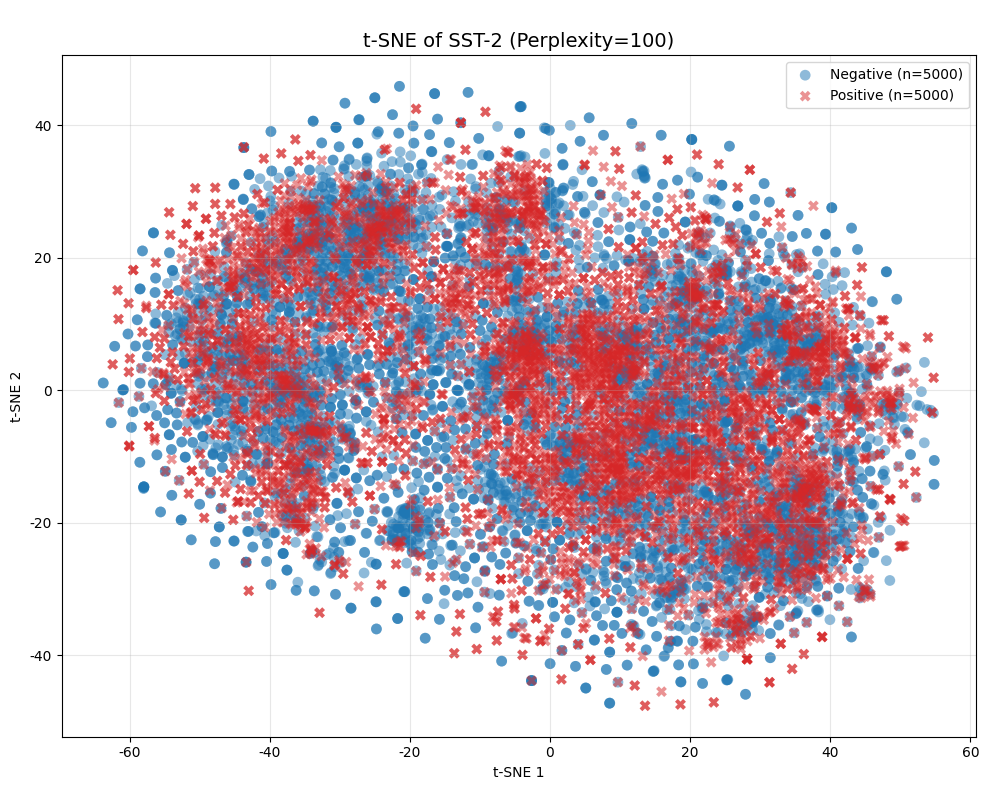

t-SNE plot saved to: results_sst2_distilroberta_20250827_021326/tsne_pretrained_distilroberta_perp100.png
All visualizations saved in: results_sst2_distilroberta_20250827_021326


In [8]:
import os  
import random  
import time  
import numpy as np  
import pandas as pd  
import tensorflow as tf  
import matplotlib.pyplot as plt  
from sklearn.manifold import TSNE  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.decomposition import PCA  

from datasets import load_dataset  
from transformers import (  
    AutoTokenizer,   
    TFAutoModelForSequenceClassification,  
    create_optimizer  
)  

# Set Hugging Face endpoint before loading dataset  
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'  

# Load SST-2 dataset  
ds = load_dataset("glue", "sst2")  
raw_train_dataset = ds['train']  
raw_test_dataset = ds['validation']  
print(f"Training set shape: {raw_train_dataset.shape}")  
print(f"Test set shape: {raw_test_dataset.shape}")  

# *** EXTRACT TEXTS AND LABELS HERE (BEFORE t-SNE SECTION) ***  
train_texts = list(raw_train_dataset['sentence'])  
train_labels = list(raw_train_dataset['label'])  
test_texts = list(raw_test_dataset['sentence'])  
test_labels = list(raw_test_dataset['label'])  

print(f"Training samples: {len(train_texts)}")  
print(f"Test samples: {len(test_texts)}")  
print(f"Sample training text: {train_texts[0]}")  
print(f"Sample training label: {train_labels[0]}")  

# Initialize tokenizer early  
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")  
max_length = 256  

def set_seed(seed):  
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  
    random.seed(seed)  
    np.random.seed(seed)  
    tf.random.set_seed(seed)  



def sample_balanced_data(texts, labels, max_samples, random_state=42):  
    """Sample data while maintaining class balance"""  
    texts = np.array(texts)  
    labels = np.array(labels)  
    
    # Get unique labels and their counts  
    unique_labels, label_counts = np.unique(labels, return_counts=True)  
    print(f"Original label distribution: {dict(zip(unique_labels, label_counts))}")  
    
    # Calculate samples per class  
    samples_per_class = max_samples // len(unique_labels)  
    
    sampled_indices = []  
    np.random.seed(random_state)  
    
    for label in unique_labels:  
        label_indices = np.where(labels == label)[0]  
        if len(label_indices) > samples_per_class:  
            # Sample without replacement  
            selected_indices = np.random.choice(label_indices, samples_per_class, replace=False)  
        else:  
            # Use all available samples  
            selected_indices = label_indices  
        sampled_indices.extend(selected_indices)  
    
    sampled_indices = np.array(sampled_indices)  
    np.random.shuffle(sampled_indices)  # Shuffle the final indices  
    
    sampled_texts = texts[sampled_indices].tolist()  
    sampled_labels = labels[sampled_indices]  
    
    # Check final distribution  
    unique_sampled, sampled_counts = np.unique(sampled_labels, return_counts=True)  
    print(f"Sampled label distribution: {dict(zip(unique_sampled, sampled_counts))} (Total: {len(sampled_labels)})")  
    
    return sampled_texts, sampled_labels.tolist()  

def extract_pretrained_embeddings(texts, labels, tokenizer, max_samples=2000, random_state=42):  
    """Extract embeddings from pre-trained DistilRoBERTa (before fine-tuning)"""        
    print(f"Extracting pre-trained DistilRoBERTa embeddings from {len(texts)} texts (max: {max_samples})...")  
    
    # Sample data if needed  
    if len(texts) > max_samples:  
        texts, labels = sample_balanced_data(texts, labels, max_samples, random_state)  
    
    # Load pre-trained model (not fine-tuned)  
    pretrained_model = TFAutoModelForSequenceClassification.from_pretrained(  
        "distilroberta-base",   
        num_labels=2  
    )  
    
    # Tokenize the subset of texts  
    encodings = tokenizer(  
        texts,  
        truncation=True,  
        padding='max_length',  
        max_length=256,  
        return_tensors='tf'  
    )  
    
    # Process in batches to avoid memory issues  
    batch_size = 32  
    total_samples = len(texts)  
    
    embeddings = []  
    processed_labels = []  
    
    try:  
        for i in range(0, total_samples, batch_size):  
            end_idx = min(i + batch_size, total_samples)  
            batch_inputs = {  
                'input_ids': encodings['input_ids'][i:end_idx],  
                'attention_mask': encodings['attention_mask'][i:end_idx]  
            }  
            batch_labels = labels[i:end_idx]  
            
            # Get model outputs (including hidden states)  
            outputs = pretrained_model(batch_inputs, output_hidden_states=True)  
            # Use [CLS] token embeddings from the last hidden layer  
            cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token  
            
            embeddings.append(cls_embeddings.numpy())  
            processed_labels.extend(batch_labels)  
            
            print(f"Processed batch {i//batch_size + 1}/{(total_samples-1)//batch_size + 1}")  
            
    except Exception as e:  
        print(f"Warning: Error during embedding extraction: {e}")  
        print("Continuing with available embeddings...")  
    
    if embeddings:  
        embeddings = np.vstack(embeddings)  
        print(f"Pre-trained embeddings shape: {embeddings.shape}")  
        return embeddings, np.array(processed_labels)  
    else:  
        print("No embeddings could be extracted")  
        return None, None  


def plot_single_tsne(embeddings, labels,  save_path, perplexity):  
    """Create single t-SNE visualization"""  
    
    print(f"Computing t-SNE: (perplexity={perplexity})...")  
    
    try:  
        # Apply t-SNE with version compatibility  
        tsne =  TSNE(n_components=2, random_state=42, perplexity=perplexity)  
        embeddings_2d = tsne.fit_transform(embeddings)  
        
        # Create the plot  
        plt.figure(figsize=(10, 8))  
        
        tab10_cmap = plt.get_cmap('tab10')  
        class_names = ['Negative', 'Positive']  
        markers = ['o', 'X']
        colors = [tab10_cmap(0), tab10_cmap(3)] 
        for i in range(2):  
            mask = labels == i  
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],  marker=markers[i], 
                       color=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',  
                       alpha=0.5, s=60,edgecolors='none')
        
        plt.title(f'\nt-SNE of SST-2 (Perplexity={perplexity})', fontsize=14)
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"t-SNE plot saved to: {save_path}")

    except Exception as e:
        print(f"Error generating t-SNE plot for {title}: {e}")
        plt.figure(figsize=(10, 8))
        plt.text(0.5, 0.5, f't-SNE visualization failed for {title}\nError: {str(e)}',
                 ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title(f' Visualization Failed', fontsize=14)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

print("\n" + "="*60)
print("GENERATING PRE-TRAINING t-SNE VISUALIZATIONS")
print("="*60)
set_seed(42) 
output_dir = f"results_sst2_distilroberta_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(output_dir, exist_ok=True)

MAX_VIZ_SAMPLES = 10000
PERPLEXITIES = [100]  # Try several perplexity values

print(f"Will sample up to {MAX_VIZ_SAMPLES} samples for t-SNE visualization")

pretrained_embeddings, pretrained_labels = extract_pretrained_embeddings(
    train_texts,  train_labels, tokenizer,
    max_samples=MAX_VIZ_SAMPLES, random_state=42
)


for perplexity in PERPLEXITIES:    
    if pretrained_embeddings is not None:
        pretrained_path = os.path.join(output_dir, f"tsne_pretrained_distilroberta_perp{perplexity}.png")
        plot_single_tsne(
            pretrained_embeddings, pretrained_labels,
            pretrained_path, perplexity
        )
    


print(f"All visualizations saved in: {output_dir}")


✓ sklearn available - t-SNE visualization enabled
Training set shape: (67349, 3)
Test set shape: (872, 3)
Training samples: 67349
Test samples: 872
Sample training text: hide new secretions from the parental units 
Sample training label: 0

GENERATING PRE-TRAINING t-SNE VISUALIZATIONS
Using TRAINING SET for visualization: 67349 total samples
Will sample up to 10000 samples for t-SNE visualization
Creating TF-IDF embeddings from 67349 texts (max: 10000)...
Original label distribution: {np.int64(0): np.int64(29780), np.int64(1): np.int64(37569)}
Sampled label distribution: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000)} (Total: 10000)
TF-IDF matrix shape: (10000, 5000)
Applied PCA: 5000 -> 100 dimensions
Extracting pre-trained DistilRoBERTa embeddings from 67349 texts (max: 10000)...
Original label distribution: {np.int64(0): np.int64(29780), np.int64(1): np.int64(37569)}
Sampled label distribution: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000)} (Total: 10000)


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed batch 1/313
Processed batch 2/313
Processed batch 3/313
Processed batch 4/313
Processed batch 5/313
Processed batch 6/313
Processed batch 7/313
Processed batch 8/313
Processed batch 9/313
Processed batch 10/313
Processed batch 11/313
Processed batch 12/313
Processed batch 13/313
Processed batch 14/313
Processed batch 15/313
Processed batch 16/313
Processed batch 17/313
Processed batch 18/313
Processed batch 19/313
Processed batch 20/313
Processed batch 21/313
Processed batch 22/313
Processed batch 23/313
Processed batch 24/313
Processed batch 25/313
Processed batch 26/313
Processed batch 27/313
Processed batch 28/313
Processed batch 29/313
Processed batch 30/313
Processed batch 31/313
Processed batch 32/313
Processed batch 33/313
Processed batch 34/313
Processed batch 35/313
Processed batch 36/313
Processed batch 37/313
Processed batch 38/313
Processed batch 39/313
Processed batch 40/313
Processed batch 41/313
Processed batch 42/313
Processed batch 43/313
Processed batch 44/3

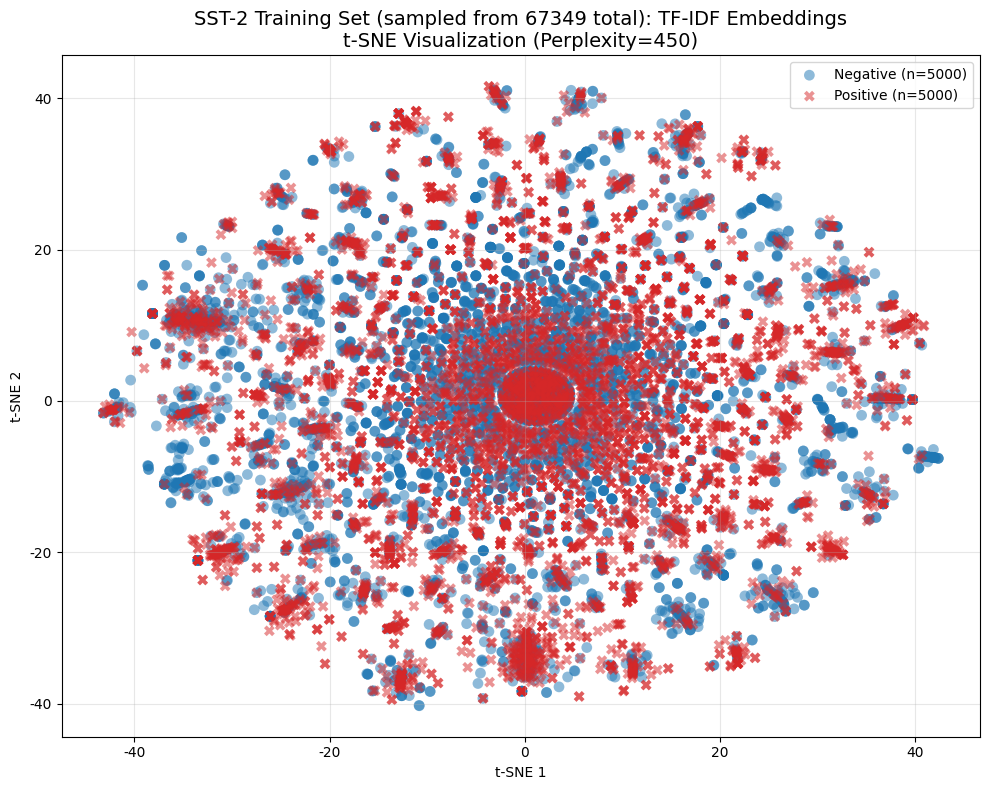

t-SNE plot saved to: results_sst2_distilroberta_TF_20250827_014400/tsne_tfidf_pretraining_train_perp450.png
Computing t-SNE for SST-2 Training Set (sampled from 67349 total): Pre-trained DistilRoBERTa (perplexity=450)...


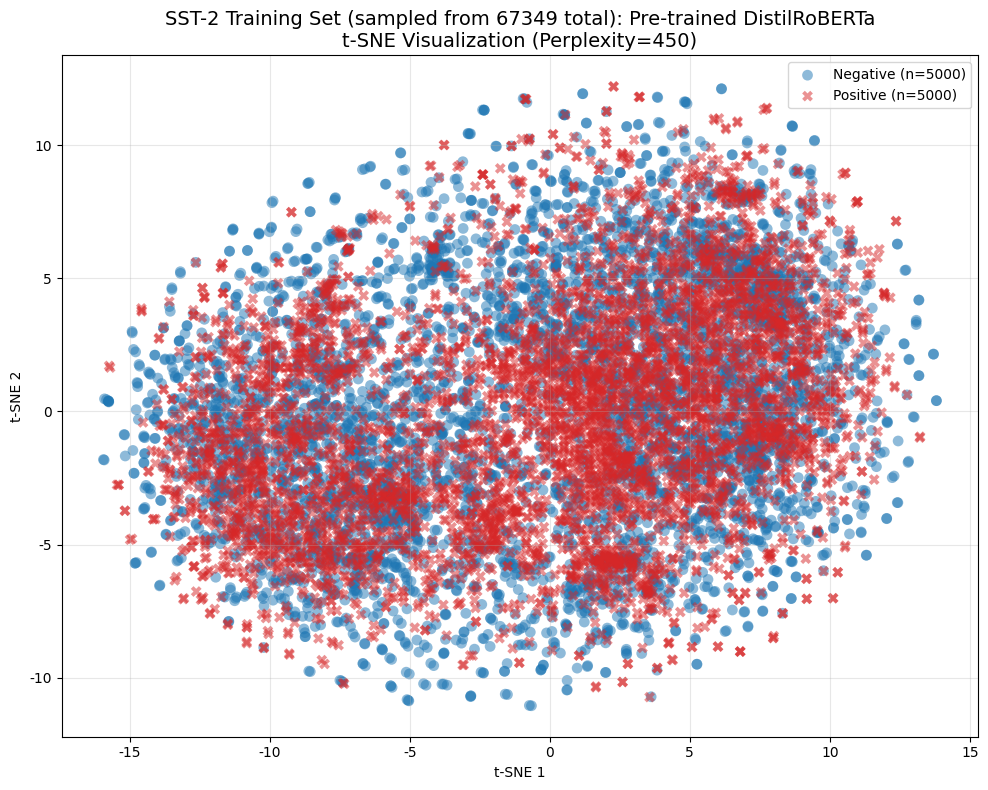

t-SNE plot saved to: results_sst2_distilroberta_TF_20250827_014400/tsne_pretrained_distilroberta_train_perp450.png
Computing t-SNE for TF-IDF embeddings (perplexity=450)...


KeyboardInterrupt: 

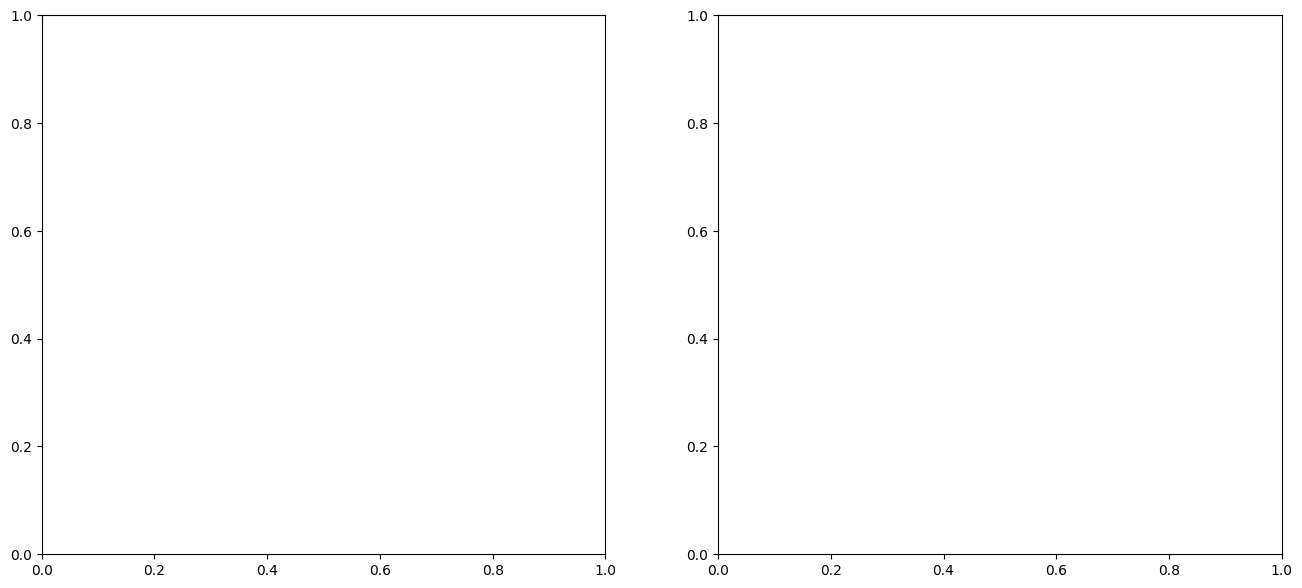

In [26]:
import os  
import random  
import time  
import numpy as np  
import pandas as pd  
import tensorflow as tf  
import matplotlib.pyplot as plt  

# Handle sklearn import gracefully at the very beginning  
SKLEARN_AVAILABLE = False  
TSNE = None  
TfidfVectorizer = None  
PCA = None  

try:  
    from sklearn.manifold import TSNE  
    from sklearn.feature_extraction.text import TfidfVectorizer  
    from sklearn.decomposition import PCA  
    SKLEARN_AVAILABLE = True  
    print("✓ sklearn available - t-SNE visualization enabled")  
except ImportError:  
    print("⚠ sklearn not available. Attempting to install...")  
    import subprocess  
    import sys  
    try:  
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])  
        from sklearn.manifold import TSNE  
        from sklearn.feature_extraction.text import TfidfVectorizer  
        from sklearn.decomposition import PCA  
        SKLEARN_AVAILABLE = True  
        print("✓ sklearn installed and imported successfully")  
    except Exception as e:  
        print(f"✗ Could not install sklearn: {e}")  
        print("Continuing without t-SNE visualization...")  
        SKLEARN_AVAILABLE = False  

from datasets import load_dataset  
from transformers import (  
    AutoTokenizer,   
    TFAutoModelForSequenceClassification,  
    create_optimizer  
)  

# Set Hugging Face endpoint before loading dataset  
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'  

# Load SST-2 dataset  
ds = load_dataset("glue", "sst2")  
raw_train_dataset = ds['train']  
raw_test_dataset = ds['validation']  # SST-2 uses 'validation' split for testing  
print(f"Training set shape: {raw_train_dataset.shape}")  
print(f"Test set shape: {raw_test_dataset.shape}")  

# *** EXTRACT TEXTS AND LABELS HERE (BEFORE t-SNE SECTION) ***  
train_texts = list(raw_train_dataset['sentence'])  
train_labels = list(raw_train_dataset['label'])  
test_texts = list(raw_test_dataset['sentence'])  
test_labels = list(raw_test_dataset['label'])  

print(f"Training samples: {len(train_texts)}")  
print(f"Test samples: {len(test_texts)}")  
print(f"Sample training text: {train_texts[0]}")  
print(f"Sample training label: {train_labels[0]}")  

# Initialize tokenizer early  
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")  
max_length = 256  

def set_seed(seed):  
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  
    random.seed(seed)  
    np.random.seed(seed)  
    tf.random.set_seed(seed)  

def create_tsne_with_version_compatibility(n_components=2, random_state=42, perplexity=30, learning_rate=200):  
    """Create t-SNE object with version compatibility for parameter names"""  
    try:  
        # Try newer parameter name first (max_iter)  
        return TSNE(n_components=n_components, random_state=random_state,   
                   perplexity=perplexity, max_iter=1000, learning_rate=learning_rate)  
    except TypeError:  
        try:  
            # Fall back to older parameter name (n_iter)  
            return TSNE(n_components=n_components, random_state=random_state,   
                       perplexity=perplexity, n_iter=1000, learning_rate=learning_rate)  
        except TypeError:  
            # Minimal parameters if both fail  
            return TSNE(n_components=n_components, random_state=random_state,   
                       perplexity=perplexity)  

def sample_balanced_data(texts, labels, max_samples, random_state=42):  
    """Sample data while maintaining class balance"""  
    texts = np.array(texts)  
    labels = np.array(labels)  
    
    # Get unique labels and their counts  
    unique_labels, label_counts = np.unique(labels, return_counts=True)  
    print(f"Original label distribution: {dict(zip(unique_labels, label_counts))}")  
    
    # Calculate samples per class  
    samples_per_class = max_samples // len(unique_labels)  
    
    sampled_indices = []  
    np.random.seed(random_state)  
    
    for label in unique_labels:  
        label_indices = np.where(labels == label)[0]  
        if len(label_indices) > samples_per_class:  
            # Sample without replacement  
            selected_indices = np.random.choice(label_indices, samples_per_class, replace=False)  
        else:  
            # Use all available samples  
            selected_indices = label_indices  
        sampled_indices.extend(selected_indices)  
    
    sampled_indices = np.array(sampled_indices)  
    np.random.shuffle(sampled_indices)  # Shuffle the final indices  
    
    sampled_texts = texts[sampled_indices].tolist()  
    sampled_labels = labels[sampled_indices]  
    
    # Check final distribution  
    unique_sampled, sampled_counts = np.unique(sampled_labels, return_counts=True)  
    print(f"Sampled label distribution: {dict(zip(unique_sampled, sampled_counts))} (Total: {len(sampled_labels)})")  
    
    return sampled_texts, sampled_labels.tolist()  

def create_tfidf_embeddings(texts, labels, max_samples=2000, random_state=42):  
    """Create TF-IDF embeddings for comparison"""  
    if not SKLEARN_AVAILABLE:  
        print("sklearn not available - skipping TF-IDF embeddings")  
        return None, None  
    
    print(f"Creating TF-IDF embeddings from {len(texts)} texts (max: {max_samples})...")  
    
    # Sample data if needed  
    if len(texts) > max_samples:  
        texts, labels = sample_balanced_data(texts, labels, max_samples, random_state)  
    
    # Create TF-IDF vectorizer  
    vectorizer = TfidfVectorizer(  
        max_features=5000,  # Limit features for t-SNE efficiency  
        stop_words='english',  
        ngram_range=(1, 2),  # Include bigrams  
        min_df=2,  # Minimum document frequency  
        max_df=0.95  # Maximum document frequency  
    )  
    
    # Fit and transform texts  
    tfidf_matrix = vectorizer.fit_transform(texts)  
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")  
    
    # Convert to dense array for t-SNE  
    tfidf_embeddings = tfidf_matrix.toarray()  
    
    # Optional: Apply PCA for dimensionality reduction before t-SNE  
    if tfidf_embeddings.shape[1] > 100:  
        pca = PCA(n_components=100, random_state=42)  
        tfidf_embeddings = pca.fit_transform(tfidf_embeddings)  
        print(f"Applied PCA: {tfidf_matrix.shape[1]} -> {tfidf_embeddings.shape[1]} dimensions")  
    
    return tfidf_embeddings, np.array(labels)  

def extract_pretrained_embeddings(texts, labels, tokenizer, max_samples=2000, random_state=42):  
    """Extract embeddings from pre-trained DistilRoBERTa (before fine-tuning)"""  
    if not SKLEARN_AVAILABLE:  
        return None, None  
        
    print(f"Extracting pre-trained DistilRoBERTa embeddings from {len(texts)} texts (max: {max_samples})...")  
    
    # Sample data if needed  
    if len(texts) > max_samples:  
        texts, labels = sample_balanced_data(texts, labels, max_samples, random_state)  
    
    # Load pre-trained model (not fine-tuned)  
    pretrained_model = TFAutoModelForSequenceClassification.from_pretrained(  
        "distilroberta-base",   
        num_labels=2  
    )  
    
    # Tokenize the subset of texts  
    encodings = tokenizer(  
        texts,  
        truncation=True,  
        padding='max_length',  
        max_length=256,  
        return_tensors='tf'  
    )  
    
    # Process in batches to avoid memory issues  
    batch_size = 32  
    total_samples = len(texts)  
    
    embeddings = []  
    processed_labels = []  
    
    try:  
        for i in range(0, total_samples, batch_size):  
            end_idx = min(i + batch_size, total_samples)  
            batch_inputs = {  
                'input_ids': encodings['input_ids'][i:end_idx],  
                'attention_mask': encodings['attention_mask'][i:end_idx]  
            }  
            batch_labels = labels[i:end_idx]  
            
            # Get model outputs (including hidden states)  
            outputs = pretrained_model(batch_inputs, output_hidden_states=True)  
            # Use [CLS] token embeddings from the last hidden layer  
            cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token  
            
            embeddings.append(cls_embeddings.numpy())  
            processed_labels.extend(batch_labels)  
            
            print(f"Processed batch {i//batch_size + 1}/{(total_samples-1)//batch_size + 1}")  
            
    except Exception as e:  
        print(f"Warning: Error during embedding extraction: {e}")  
        print("Continuing with available embeddings...")  
    
    if embeddings:  
        embeddings = np.vstack(embeddings)  
        print(f"Pre-trained embeddings shape: {embeddings.shape}")  
        return embeddings, np.array(processed_labels)  
    else:  
        print("No embeddings could be extracted")  
        return None, None  
tab10_cmap = plt.get_cmap('tab10')

def plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, tfidf_labels, pretrained_labels,   
                        save_path, perplexity, dataset_name="Dataset"):  
    """Create side-by-side t-SNE comparison plots"""  
    if not SKLEARN_AVAILABLE:  
        print("sklearn not available - skipping t-SNE visualization")  
        return  
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))  
    
    # Define colors and labels for sentiment classes  
    #colors = ['red', 'blue']  
    class_names = ['Negative', 'Positive']  
    markers = ['o', 'X']
    #colors = ['#FF6B6B', '#4ECDC4']
    colors = [tab10_cmap(0), tab10_cmap(3)]
    # Plot 1: TF-IDF embeddings  
    if tfidf_embeddings is not None:  
        print(f"Computing t-SNE for TF-IDF embeddings (perplexity={perplexity})...")  
        try:  
            tsne_tfidf = create_tsne_with_version_compatibility(perplexity=perplexity)  
            tfidf_2d = tsne_tfidf.fit_transform(tfidf_embeddings)  
            
            for i in range(2):  
                mask = tfidf_labels == i  
                axes[0].scatter(tfidf_2d[mask, 0], tfidf_2d[mask, 1],   
                               color=colors[i], marker=markers[i], label=f'{class_names[i]} (n={np.sum(mask)})',   
                               alpha=0.6, s=20)  
            
            axes[0].set_title(f'TF-IDF Embeddings\n(Traditional Bag-of-Words)\nPerplexity={perplexity}', fontsize=12)  
            axes[0].set_xlabel('t-SNE 1')  
            axes[0].set_ylabel('t-SNE 2')  
            axes[0].legend()  
            axes[0].grid(True, alpha=0.3)  
        except Exception as e:  
            print(f"Error computing t-SNE for TF-IDF: {e}")  
            axes[0].text(0.5, 0.5, f'TF-IDF t-SNE failed:\n{str(e)}',   
                        ha='center', va='center', transform=axes[0].transAxes)  
    
    # Plot 2: Pre-trained DistilRoBERTa embeddings  
    if pretrained_embeddings is not None:  
        print(f"Computing t-SNE for pre-trained DistilRoBERTa embeddings (perplexity={perplexity})...")  
        try:  
            tsne_pretrained = create_tsne_with_version_compatibility(perplexity=perplexity)  
            pretrained_2d = tsne_pretrained.fit_transform(pretrained_embeddings)  
            
            for i in range(2):  
                mask = pretrained_labels == i  
                axes[1].scatter(pretrained_2d[mask, 0], pretrained_2d[mask, 1],   
                               color=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',  
                               alpha=0.5,edgecolors='none', s=60)  
            
            axes[1].set_title(f'Pre-trained DistilRoBERTa Embeddings\n(Before Fine-tuning)\nPerplexity={perplexity}', fontsize=12)  
            axes[1].set_xlabel('t-SNE 1')  
            axes[1].set_ylabel('t-SNE 2')  
            axes[1].legend()  
            axes[1].grid(True, alpha=0.3)  
        except Exception as e:  
            print(f"Error computing t-SNE for DistilRoBERTa: {e}")  
            axes[1].text(0.5, 0.5, f'DistilRoBERTa t-SNE failed:\n{str(e)}',   
                        ha='center', va='center', transform=axes[1].transAxes)  
    
    plt.suptitle(f'SST-2 {dataset_name}: Embedding Comparison (Perplexity={perplexity})', fontsize=14, y=0.98)  
    plt.tight_layout()  
    
    # Save the plot  
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  
    plt.show()  
    plt.close()  
    
    print(f"Pre-training t-SNE comparison plot (perplexity={perplexity}) saved to: {save_path}")  

def plot_single_tsne(embeddings, labels, title, save_path, perplexity):  
    """Create single t-SNE visualization"""  
    if not SKLEARN_AVAILABLE or embeddings is None:  
        print(f"Skipping t-SNE plot: {title}")  
        return  
    
    print(f"Computing t-SNE for {title} (perplexity={perplexity})...")  
    
    try:  
        # Apply t-SNE with version compatibility  
        tsne = create_tsne_with_version_compatibility(perplexity=perplexity)  
        embeddings_2d = tsne.fit_transform(embeddings)  
        
        # Create the plot  
        plt.figure(figsize=(10, 8))  
        
        # Define colors and labels for sentiment classes  
        #colors = ['red', 'blue']  
        class_names = ['Negative', 'Positive']  
        markers = ['o', 'X']
        #colors = ['#FF6B6B', '#4ECDC4']
        colors = [tab10_cmap(0), tab10_cmap(3)] 
        for i in range(2):  
            mask = labels == i  
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],  marker=markers[i], 
                       color=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',  
                       alpha=0.5, s=60,edgecolors='none')
        
        plt.title(f'{title}\nt-SNE Visualization (Perplexity={perplexity})', fontsize=14)
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save the plot
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"t-SNE plot saved to: {save_path}")

    except Exception as e:
        print(f"Error generating t-SNE plot for {title}: {e}")
        plt.figure(figsize=(10, 8))
        plt.text(0.5, 0.5, f't-SNE visualization failed for {title}\nError: {str(e)}',
                 ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title(f'{title} - Visualization Failed', fontsize=14)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

# Load your custom font
import matplotlib.font_manager as fm
font_path = '/mnt/data/file-ngwyeoEN29l1M3O1QpdxCwkj-sider-font.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False

# --- t-SNE Visualization Section ---
print("\n" + "="*60)
print("GENERATING PRE-TRAINING t-SNE VISUALIZATIONS")
print("="*60)

output_dir = f"results_sst2_distilroberta_TF_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(output_dir, exist_ok=True)

# CONFIGURATION
USE_TRAIN_SET = True
MAX_VIZ_SAMPLES = 10000
PERPLEXITIES = [ 450,550,600,750]  # Try several perplexity values

if SKLEARN_AVAILABLE:
    if USE_TRAIN_SET:
        visualization_texts = train_texts
        visualization_labels = train_labels
        dataset_name = f"Training Set (sampled from {len(train_texts)} total)"
        print(f"Using TRAINING SET for visualization: {len(visualization_texts)} total samples")
    else:
        visualization_texts = test_texts
        visualization_labels = test_labels
        dataset_name = f"Test Set ({len(test_texts)} total)"
        print(f"Using TEST SET for visualization: {len(visualization_texts)} total samples")
    print(f"Will sample up to {MAX_VIZ_SAMPLES} samples for t-SNE visualization")

    # Create TF-IDF and RoBERTa embeddings (once!)
    tfidf_embeddings, tfidf_labels = create_tfidf_embeddings(
        visualization_texts, visualization_labels,
        max_samples=MAX_VIZ_SAMPLES, random_state=42
    )
    pretrained_embeddings, pretrained_labels = extract_pretrained_embeddings(
        visualization_texts, visualization_labels, tokenizer,
        max_samples=MAX_VIZ_SAMPLES, random_state=42
    )
    dataset_suffix = "train" if USE_TRAIN_SET else "test"

    for perplexity in PERPLEXITIES:
        # Individual plots
        if tfidf_embeddings is not None:
            tfidf_path = os.path.join(output_dir, f"tsne_tfidf_pretraining_{dataset_suffix}_perp{perplexity}.png")
            plot_single_tsne(
                tfidf_embeddings, tfidf_labels,
                f"SST-2 {dataset_name}: TF-IDF Embeddings",
                tfidf_path, perplexity
            )
        if pretrained_embeddings is not None:
            pretrained_path = os.path.join(output_dir, f"tsne_pretrained_distilroberta_{dataset_suffix}_perp{perplexity}.png")
            plot_single_tsne(
                pretrained_embeddings, pretrained_labels,
                f"SST-2 {dataset_name}: Pre-trained DistilRoBERTa",
                pretrained_path, perplexity
            )
        # Side-by-side comparison
        if tfidf_embeddings is not None or pretrained_embeddings is not None:
            comparison_path = os.path.join(output_dir, f"tsne_comparison_pretraining_{dataset_suffix}_perp{perplexity}.png")
            plot_tsne_comparison(
                tfidf_embeddings, pretrained_embeddings,
                tfidf_labels, pretrained_labels, comparison_path,
                perplexity, dataset_name=dataset_name
            )

    print(f"\n✓ Pre-training t-SNE visualizations with multiple perplexity values completed!")
    print(f"All visualizations saved in: {output_dir}")
else:
    print("\n⚠ Skipping t-SNE visualizations (sklearn not available)")


import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Handle sklearn import gracefully at the very beginning
SKLEARN_AVAILABLE = False
TSNE = None
TfidfVectorizer = None
PCA = None

try:
    from sklearn.manifold import TSNE
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import PCA
    SKLEARN_AVAILABLE = True
    print("✓ sklearn available - t-SNE visualization enabled")
except ImportError:
    print("⚠ sklearn not available. Attempting to install...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
        from sklearn.manifold import TSNE
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import PCA
        SKLEARN_AVAILABLE = True
        print("✓ sklearn installed and imported successfully")
    except Exception as e:
        print(f"✗ Could not install sklearn: {e}")
        print("Continuing without t-SNE visualization...")
        SKLEARN_AVAILABLE = False

from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    TFAutoModelForSequenceClassification,
    create_optimizer
)

# Set Hugging Face endpoint before loading dataset
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# Load SST-2 dataset
ds = load_dataset("glue", "sst2")
raw_train_dataset = ds['train']
raw_test_dataset = ds['validation']  # SST-2 uses 'validation' split for testing
print(raw_train_dataset.shape)
print(raw_test_dataset.shape)

def set_seed(seed):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def create_tsne_with_version_compatibility(n_components=2, random_state=42, perplexity=30, learning_rate=200):
    """Create t-SNE object with version compatibility for parameter names"""
    try:
        # Try newer parameter name first (max_iter)
        return TSNE(n_components=n_components, random_state=random_state, 
                   perplexity=perplexity, max_iter=1000, learning_rate=learning_rate)
    except TypeError:
        try:
            # Fall back to older parameter name (n_iter)
            return TSNE(n_components=n_components, random_state=random_state, 
                       perplexity=perplexity, n_iter=1000, learning_rate=learning_rate)
        except TypeError:
            # Minimal parameters if both fail
            return TSNE(n_components=n_components, random_state=random_state, 
                       perplexity=perplexity)

def create_tfidf_embeddings(texts, labels, max_samples=1000):
    """Create TF-IDF embeddings for comparison"""
    if not SKLEARN_AVAILABLE:
        print("sklearn not available - skipping TF-IDF embeddings")
        return None, None
    
    # Limit samples for efficiency
    if len(texts) > max_samples:
        indices = np.random.choice(len(texts), max_samples, replace=False)
        texts = [texts[i] for i in indices]
        labels = [labels[i] for i in indices]
    
    print(f"Creating TF-IDF embeddings for {len(texts)} samples...")
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=5000,  # Limit features for t-SNE efficiency
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Minimum document frequency
        max_df=0.95  # Maximum document frequency
    )
    
    # Fit and transform texts
    tfidf_matrix = vectorizer.fit_transform(texts)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    
    # Convert to dense array for t-SNE
    tfidf_embeddings = tfidf_matrix.toarray()
    
    # Optional: Apply PCA for dimensionality reduction before t-SNE
    if tfidf_embeddings.shape[1] > 100:
        pca = PCA(n_components=100, random_state=42)
        tfidf_embeddings = pca.fit_transform(tfidf_embeddings)
        print(f"Applied PCA: {tfidf_matrix.shape[1]} -> {tfidf_embeddings.shape[1]} dimensions")
    
    return tfidf_embeddings, np.array(labels)

def extract_pretrained_embeddings(texts, labels, tokenizer, max_samples=1000):
    """Extract embeddings from pre-trained DistilRoBERTa (before fine-tuning)"""
    if not SKLEARN_AVAILABLE:
        return None, None
        
    print(f"Extracting pre-trained DistilRoBERTa embeddings...")
    
    # Limit samples for efficiency
    if len(texts) > max_samples:
        indices = np.random.choice(len(texts), max_samples, replace=False)
        texts = [texts[i] for i in indices]
        labels = [labels[i] for i in indices]
    
    # Load pre-trained model (not fine-tuned)
    pretrained_model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilroberta-base", 
        num_labels=2
    )
    
    # Tokenize the subset of texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors='tf'
    )
    
    # Create dataset for extraction
    dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }).batch(16)
    
    embeddings = []
    try:
        for batch in dataset:
            # Get model outputs (including hidden states)
            outputs = pretrained_model(batch, output_hidden_states=True)
            # Use [CLS] token embeddings from the last hidden layer
            cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token
            embeddings.append(cls_embeddings.numpy())
    except Exception as e:
        print(f"Warning: Error during embedding extraction: {e}")
        print("This might be due to dataset iteration. Continuing with available embeddings...")
    
    if embeddings:
        embeddings = np.vstack(embeddings)
        print(f"Pre-trained embeddings shape: {embeddings.shape}")
        return embeddings, np.array(labels)[:len(embeddings)]
    else:
        print("No embeddings could be extracted")
        return None, None

def plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, tfidf_labels, pretrained_labels, 
                        save_path, perplexity=30):
    """Create side-by-side t-SNE comparison plots"""
    if not SKLEARN_AVAILABLE:
        print("sklearn not available - skipping t-SNE visualization")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Define colors and labels for sentiment classes
    colors = ['red', 'blue']
    class_names = ['Negative', 'Positive']
    
    # Plot 1: TF-IDF embeddings
    if tfidf_embeddings is not None:
        print(f"Computing t-SNE for TF-IDF embeddings (perplexity={perplexity})...")
        try:
            tsne_tfidf = create_tsne_with_version_compatibility(perplexity=perplexity)
            tfidf_2d = tsne_tfidf.fit_transform(tfidf_embeddings)
            
            for i in range(2):
                mask = tfidf_labels == i
                axes[0].scatter(tfidf_2d[mask, 0], tfidf_2d[mask, 1], 
                               c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                               alpha=0.6, s=20)
            
            axes[0].set_title('TF-IDF Embeddings\n(Traditional Bag-of-Words)', fontsize=12)
            axes[0].set_xlabel('t-SNE Component 1')
            axes[0].set_ylabel('t-SNE Component 2')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error computing t-SNE for TF-IDF: {e}")
            axes[0].text(0.5, 0.5, f'TF-IDF t-SNE failed:\n{str(e)}', 
                        ha='center', va='center', transform=axes[0].transAxes)
    
    # Plot 2: Pre-trained DistilRoBERTa embeddings
    if pretrained_embeddings is not None:
        print(f"Computing t-SNE for pre-trained DistilRoBERTa embeddings (perplexity={perplexity})...")
        try:
            tsne_pretrained = create_tsne_with_version_compatibility(perplexity=perplexity)
            pretrained_2d = tsne_pretrained.fit_transform(pretrained_embeddings)
            
            for i in range(2):
                mask = pretrained_labels == i
                axes[1].scatter(pretrained_2d[mask, 0], pretrained_2d[mask, 1], 
                               c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                               alpha=0.6, s=20)
            
            axes[1].set_title('Pre-trained DistilRoBERTa Embeddings\n(Before Fine-tuning)', fontsize=12)
            axes[1].set_xlabel('t-SNE Component 1')
            axes[1].set_ylabel('t-SNE Component 2')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error computing t-SNE for DistilRoBERTa: {e}")
            axes[1].text(0.5, 0.5, f'DistilRoBERTa t-SNE failed:\n{str(e)}', 
                        ha='center', va='center', transform=axes[1].transAxes)
    
    plt.suptitle('SST-2 Dataset: Embedding Comparison Before Training', fontsize=14, y=0.98)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"Pre-training t-SNE comparison plot saved to: {save_path}")

def plot_single_tsne(embeddings, labels, title, save_path, perplexity=30):
    """Create single t-SNE visualization"""
    if not SKLEARN_AVAILABLE or embeddings is None:
        print(f"Skipping t-SNE plot: {title}")
        return
    
    print(f"Computing t-SNE for {title} (perplexity={perplexity})...")
    
    try:
        # Apply t-SNE with version compatibility
        tsne = create_tsne_with_version_compatibility(perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Create the plot
        plt.figure(figsize=(10, 8))
        
        # Define colors and labels for sentiment classes
        colors = ['red', 'blue']
        class_names = ['Negative', 'Positive']
        
        for i in range(2):
            mask = labels == i
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                       c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                       alpha=0.6, s=20)
        
        plt.title(f'{title}\nt-SNE Visualization', fontsize=14)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save the plot
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"t-SNE plot saved to: {save_path}")
        
    except Exception as e:
        print(f"Error generating t-SNE plot for {title}: {e}")
        # Create a simple error plot
        plt.figure(figsize=(10, 8))
        plt.text(0.5, 0.5, f't-SNE visualization failed for {title}\nError: {str(e)}', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title(f'{title} - Visualization Failed', fontsize=14)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

base_seed = 42
num_epochs = 2
num_runs_per_trial = 1
num_trials = 1
batch_size = 16

all_runs_results, all_histories, cv_train_list, cv_test_list = [], [], [], []

# GPU setup
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_type = "CPU"
if gpu_devices:
    gpu_type = "_".join([dev.name.split(':')[-1] for dev in gpu_devices])
    print(f"Using GPU(s): {gpu_type}")
    # Configure GPU memory growth
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

# Use DistilRoBERTa tokenizer (consistent naming)
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
max_length = 256

# Extract text and labels as lists
train_texts = list(raw_train_dataset['sentence'])
train_labels = list(raw_train_dataset['label'])
test_texts = list(raw_test_dataset['sentence'])
test_labels = list(raw_test_dataset['label'])

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Sample training text: {train_texts[0]}")
print(f"Sample training label: {train_labels[0]}")

# Tokenize datasets
train_encodings = tokenizer(
    train_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)
test_encodings = tokenizer(
    test_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ========================================
# PRE-TRAINING t-SNE VISUALIZATION
# ========================================
print("\n" + "="*60)
print("GENERATING PRE-TRAINING t-SNE VISUALIZATIONS")
print("="*60)

# Create output directory for visualizations
output_dir = f"results_sst2_distilroberta_TF_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(output_dir, exist_ok=True)

if SKLEARN_AVAILABLE:
    # Use test dataset for visualization (smaller and more manageable)
    visualization_texts = test_texts
    visualization_labels = test_labels
    max_viz_samples = 800  # Reduced for stability
    
    print(f"Creating embeddings for {len(visualization_texts)} samples (max: {max_viz_samples})...")
    
    # 1. Create TF-IDF embeddings
    print("\n--- Creating TF-IDF Embeddings ---")
    tfidf_embeddings, tfidf_labels = create_tfidf_embeddings(
        visualization_texts, visualization_labels, max_samples=max_viz_samples
    )
    
    # 2. Extract pre-trained DistilRoBERTa embeddings
    print("\n--- Extracting Pre-trained DistilRoBERTa Embeddings ---")
    pretrained_embeddings, pretrained_labels = extract_pretrained_embeddings(
        visualization_texts, visualization_labels, tokenizer, max_samples=max_viz_samples
    )
    
    # 3. Generate t-SNE visualizations
    print("\n--- Generating t-SNE Visualizations ---")
    
    # Individual plots
    if tfidf_embeddings is not None:
        tfidf_path = os.path.join(output_dir, "tsne_tfidf_pretraining.png")
        plot_single_tsne(tfidf_embeddings, tfidf_labels, 
                        "SST-2 Dataset: TF-IDF Embeddings", tfidf_path)
    
    if pretrained_embeddings is not None:
        pretrained_path = os.path.join(output_dir, "tsne_pretrained_distilroberta.png")
        plot_single_tsne(pretrained_embeddings, pretrained_labels,
                        "SST-2 Dataset: Pre-trained DistilRoBERTa", pretrained_path)
    
    # Comparison plot
    if tfidf_embeddings is not None or pretrained_embeddings is not None:
        comparison_path = os.path.join(output_dir, "tsne_comparison_pretraining.png")
        plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, 
                           tfidf_labels, pretrained_labels, comparison_path)
        
        # Alternative perplexity (only if both embeddings are available)
        if tfidf_embeddings is not None and pretrained_embeddings is not None:
            comparison_path_alt = os.path.join(output_dir, "tsne_comparison_pretraining_perp50.png")
            plot_tsne_comparison(tfidf_embeddings, pretrained_embeddings, 
                               tfidf_labels, pretrained_labels, comparison_path_alt, perplexity=50)
    
    print("\n✓ Pre-training t-SNE visualizations completed!")
    print(f"✓ Visualizations saved in: {output_dir}")
    
else:
    print("\n⚠ Skipping pre-training t-SNE visualizations (sklearn not available)")

print("\n" + "="*60)
print("STARTING MODEL TRAINING")
print("="*60)

# ========================================
# ORIGINAL TRAINING CODE CONTINUES HERE
# ========================================

for trial_idx in range(num_trials):
    print(f"\n======= Trial {trial_idx+1}/{num_trials} =======")
    trial_train_accuracies, trial_test_accuracies = [], []

    for run_idx in range(num_runs_per_trial):
        current_seed = base_seed + trial_idx * 1000 + run_idx
        print(f"\n--- Trial {trial_idx+1}, Run {run_idx+1}/{num_runs_per_trial} | seed={current_seed} ---")
        set_seed(current_seed)

        # Load DistilRoBERTa model for sequence classification
        model = TFAutoModelForSequenceClassification.from_pretrained(
            "distilroberta-base", 
            num_labels=2
        )
        
        print("Model summary:")
        print(f"Model parameters: {model.num_parameters():,}")

        # Calculate training steps
        num_training_steps = len(train_texts) // batch_size * num_epochs
        
        # Create optimizer with warmup
        optimizer, schedule = create_optimizer(
            init_lr=5e-6,
            num_train_steps=num_training_steps,
            num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
            weight_decay_rate=0.01
        )

        # Compile model
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy']
        )

        # Training callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        history = model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=1
        )

        # Get final metrics
        final_train_acc = history.history["accuracy"][-1]
        final_val_acc = history.history["val_accuracy"][-1]
        final_train_loss = history.history["loss"][-1]
        final_val_loss = history.history["val_loss"][-1]
        
        print(f"Run {run_idx+1} Final -> Train Acc: {final_train_acc*100:.2f}%, Test Acc: {final_val_acc*100:.2f}%")
        
        all_runs_results.append((
            final_train_loss, final_train_acc, final_val_loss, final_val_acc,
            run_idx+1, trial_idx+1
        ))
        
        trial_train_accuracies.append(final_train_acc)
        trial_test_accuracies.append(final_val_acc)
        
        # Store history
        epochs_trained = len(history.history["accuracy"])
        run_history_df = pd.DataFrame(history.history)
        run_history_df["epoch"] = np.arange(1, epochs_trained + 1)
        run_history_df["run"] = run_idx + 1
        run_history_df["trial"] = trial_idx + 1
        all_histories.append(run_history_df)
    
    # Compute CV for the trial
    train_acc_arr, test_acc_arr = np.array(trial_train_accuracies), np.array(trial_test_accuracies)
    mean_train_acc, std_train_acc = train_acc_arr.mean(), train_acc_arr.std()
    cv_train = std_train_acc / mean_train_acc if mean_train_acc != 0 else 0.0
    mean_test_acc, std_test_acc = test_acc_arr.mean(), test_acc_arr.std()
    cv_test = std_test_acc / mean_test_acc if mean_test_acc != 0 else 0.0
    
    print(f"\n*** Trial {trial_idx+1} Stats ***")
    print(f"Train Acc (Mean, Std, CV): {mean_train_acc:.4f}, {std_train_acc:.4f}, {cv_train:.4f}")
    print(f"Test  Acc (Mean, Std, CV): {mean_test_acc:.4f}, {std_test_acc:.4f}, {cv_test:.4f}")
    
    cv_train_list.append(cv_train)
    cv_test_list.append(cv_test)

# Final Analysis
if cv_train_list and cv_test_list:
    mean_cv_train, mean_cv_test = np.mean(cv_train_list), np.mean(cv_test_list)
    gpu_reproducibility, whole_reproducibility = 1.0 - mean_cv_train, 1.0 - mean_cv_test
    print("\n============================")
    print("Final Reproducibility Stats")
    print("============================")
    print(f"Mean CV (Train): {mean_cv_train:.6f} => GPU Reproducibility   = {gpu_reproducibility:.6f}")
    print(f"Mean CV (Test) : {mean_cv_test:.6f} => Whole Reproducibility = {whole_reproducibility:.6f}")

# Save results
if all_runs_results:
    columns = ["train_loss", "train_accuracy", "test_loss", "test_accuracy", "run", "trial"]
    all_runs_df = pd.DataFrame(all_runs_results, columns=columns)
    results_path = os.path.join(output_dir, f"sst2_GPU_{gpu_type}_all_runs_results.csv")
    all_runs_df.to_csv(results_path, index=False)
    print(f"\nPer-run final metrics saved to: {results_path}")

if all_histories:
    all_histories_df = pd.concat(all_histories, ignore_index=True)
    history_path = os.path.join(output_dir, "training_history.csv")
    all_histories_df.to_csv(history_path, index=False)
    print(f"Detailed epoch-by-epoch history saved to: {history_path}")

    # Generate and Save Plots
    unique_trials = sorted(all_histories_df["trial"].unique())
    for t in unique_trials:
        trial_history = all_histories_df[all_histories_df["trial"] == t]
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), squeeze=False)
        axes = axes.ravel()
        
        for run_id in sorted(trial_history["run"].unique()):
            run_data = trial_history[trial_history["run"] == run_id]
            axes[0].plot(run_data["epoch"], run_data["loss"], marker='o', linestyle='-', 
                        label=f"Train Loss (Run {run_id})")
            axes[0].plot(run_data["epoch"], run_data["val_loss"], marker='s', linestyle='--', 
                        label=f"Val Loss (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["accuracy"], marker='o', linestyle='-', 
                        label=f"Train Acc (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["val_accuracy"], marker='s', linestyle='--', 
                        label=f"Val Acc (Run {run_id})")
        
        # Configure plots
        max_epochs = trial_history["epoch"].max()
        axes[0].set_title(f"Trial {t} - Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True)
        axes[0].legend()
        axes[0].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        axes[1].set_title(f"Trial {t} - Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        plt.suptitle(f"Metrics for Trial {t}", fontsize=16, y=1.02)
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"metrics_curves_trial_{t}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Training/Validation metrics for Trial {t} saved to: {plot_path}")

print("\nTraining completed successfully!")
print(f"All results and visualizations saved in: {output_dir}")

if SKLEARN_AVAILABLE:
    print("\n" + "="*60)
    print("GENERATED VISUALIZATIONS SUMMARY:")
    print("="*60)
    print("📊 Pre-training t-SNE plots:")
    print("   • TF-IDF embeddings")
    print("   • Pre-trained DistilRoBERTa embeddings")
    print("   • Side-by-side comparison")
    print("   • Alternative perplexity settings")
    print("📈 Training metrics plots")
    print("📁 All files saved in:", output_dir)
else:
    print("\n⚠ sklearn not available - only training plots were generated")


In [5]:

import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    TFAutoModelForSequenceClassification,
    create_optimizer
)

# Set Hugging Face endpoint before loading dataset
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# Load SST-2 dataset
ds = load_dataset("glue", "sst2")
raw_train_dataset = ds['train']
raw_test_dataset = ds['validation']  # SST-2 uses 'validation' split for testing

def set_seed(seed):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def extract_embeddings(model, dataset, max_samples=1000):
    """Extract embeddings from the model's hidden states"""
    embeddings = []
    labels = []
    sample_count = 0
    
    for batch in dataset:
        if sample_count >= max_samples:
            break
            
        inputs, batch_labels = batch
        # Get model outputs (including hidden states)
        outputs = model(inputs, output_hidden_states=True)
        
        # Use the [CLS] token embeddings (first token) from the last hidden layer
        # Hidden states shape: (batch_size, sequence_length, hidden_size)
        cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # Take [CLS] token
        
        embeddings.append(cls_embeddings.numpy())
        labels.extend(batch_labels.numpy())
        sample_count += len(batch_labels)
    
    embeddings = np.vstack(embeddings)[:max_samples]
    labels = np.array(labels)[:max_samples]
    
    return embeddings, labels

def plot_tsne(embeddings, labels, title, save_path, perplexity=30):
    """Create and save t-SNE visualization"""
    print(f"Computing t-SNE with perplexity={perplexity}...")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, 
                n_iter=1000, learning_rate=200)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Define colors and labels for sentiment classes
    colors = ['red', 'blue']
    class_names = ['Negative', 'Positive']
    
    for i in range(2):
        mask = labels == i
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                   c=colors[i], label=f'{class_names[i]} (n={np.sum(mask)})',
                   alpha=0.6, s=20)
    
    plt.title(f'{title}\nt-SNE Visualization of Learned Representations', fontsize=14)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"t-SNE plot saved to: {save_path}")

base_seed = 42
num_epochs = 150
num_runs_per_trial = 1
num_trials = 1
batch_size = 16

all_runs_results, all_histories, cv_train_list, cv_test_list = [], [], [], []

# GPU setup
gpu_devices = tf.config.list_physical_devices('GPU')
gpu_type = "CPU"
if gpu_devices:
    gpu_type = "_".join([dev.name.split(':')[-1] for dev in gpu_devices])
    print(f"Using GPU(s): {gpu_type}")
    # Configure GPU memory growth
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

# Use DistilRoBERTa tokenizer (consistent naming)
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
max_length = 256

# Extract text and labels as lists
train_texts = list(raw_train_dataset['sentence'])
train_labels = list(raw_train_dataset['label'])
test_texts = list(raw_test_dataset['sentence'])
test_labels = list(raw_test_dataset['label'])

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Sample training text: {train_texts[0]}")
print(f"Sample training label: {train_labels[0]}")

# Tokenize datasets
train_encodings = tokenizer(
    train_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)
test_encodings = tokenizer(
    test_texts, 
    truncation=True, 
    padding='max_length', 
    max_length=max_length,
    return_tensors='tf'
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For t-SNE visualization (smaller subset for efficiency)
tsne_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size)

for trial_idx in range(num_trials):
    print(f"\n======= Trial {trial_idx+1}/{num_trials} =======")
    trial_train_accuracies, trial_test_accuracies = [], []

    for run_idx in range(num_runs_per_trial):
        current_seed = base_seed + trial_idx * 1000 + run_idx
        print(f"\n--- Trial {trial_idx+1}, Run {run_idx+1}/{num_runs_per_trial} | seed={current_seed} ---")
        set_seed(current_seed)

        # Load DistilRoBERTa model for sequence classification
        model = TFAutoModelForSequenceClassification.from_pretrained(
            "distilroberta-base", 
            num_labels=2
        )
        
        print("Model summary:")
        print(f"Model parameters: {model.num_parameters():,}")

        # Calculate training steps
        num_training_steps = len(train_texts) // batch_size * num_epochs
        
        # Create optimizer with warmup
        optimizer, schedule = create_optimizer(
            init_lr=5e-6,
            num_train_steps=num_training_steps,
            num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
            weight_decay_rate=0.01
        )

        # Compile model
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy']
        )

        # Training callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        history = model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=1
        )

        # Get final metrics
        final_train_acc = history.history["accuracy"][-1]
        final_val_acc = history.history["val_accuracy"][-1]
        final_train_loss = history.history["loss"][-1]
        final_val_loss = history.history["val_loss"][-1]
        
        print(f"Run {run_idx+1} Final -> Train Acc: {final_train_acc*100:.2f}%, Test Acc: {final_val_acc*100:.2f}%")
        
        all_runs_results.append((
            final_train_loss, final_train_acc, final_val_loss, final_val_acc,
            run_idx+1, trial_idx+1
        ))
        
        trial_train_accuracies.append(final_train_acc)
        trial_test_accuracies.append(final_val_acc)
        
        # Store history
        epochs_trained = len(history.history["accuracy"])
        run_history_df = pd.DataFrame(history.history)
        run_history_df["epoch"] = np.arange(1, epochs_trained + 1)
        run_history_df["run"] = run_idx + 1
        run_history_df["trial"] = trial_idx + 1
        all_histories.append(run_history_df)
        
        # Generate t-SNE visualization for this run
        if all_runs_results:  # Only create output directory if we have results
            output_dir = f"results_sst2_distilroberta_TF_{time.strftime('%Y%m%d_%H%M%S')}"
            os.makedirs(output_dir, exist_ok=True)
            
            print("\n=== Generating t-SNE Visualization ===")
            try:
                # Extract embeddings from the trained model
                embeddings, labels = extract_embeddings(model, tsne_dataset, max_samples=1000)
                print(f"Extracted {len(embeddings)} embeddings with shape {embeddings.shape}")
                
                # Generate t-SNE plot
                tsne_title = f"SST-2 Sentiment Analysis - Trial {trial_idx+1}, Run {run_idx+1}"
                tsne_path = os.path.join(output_dir, f"tsne_trial_{trial_idx+1}_run_{run_idx+1}.png")
                plot_tsne(embeddings, labels, tsne_title, tsne_path)
                
                # Also create a plot with different perplexity for comparison
                tsne_path_alt = os.path.join(output_dir, f"tsne_trial_{trial_idx+1}_run_{run_idx+1}_perp50.png")
                plot_tsne(embeddings, labels, f"{tsne_title} (Perplexity=50)", tsne_path_alt, perplexity=50)
                
            except Exception as e:
                print(f"Error generating t-SNE visualization: {e}")
    
    # Compute CV for the trial
    train_acc_arr, test_acc_arr = np.array(trial_train_accuracies), np.array(trial_test_accuracies)
    mean_train_acc, std_train_acc = train_acc_arr.mean(), train_acc_arr.std()
    cv_train = std_train_acc / mean_train_acc if mean_train_acc != 0 else 0.0
    mean_test_acc, std_test_acc = test_acc_arr.mean(), test_acc_arr.std()
    cv_test = std_test_acc / mean_test_acc if mean_test_acc != 0 else 0.0
    
    print(f"\n*** Trial {trial_idx+1} Stats ***")
    print(f"Train Acc (Mean, Std, CV): {mean_train_acc:.4f}, {std_train_acc:.4f}, {cv_train:.4f}")
    print(f"Test  Acc (Mean, Std, CV): {mean_test_acc:.4f}, {std_test_acc:.4f}, {cv_test:.4f}")
    
    cv_train_list.append(cv_train)
    cv_test_list.append(cv_test)

# Final Analysis
if cv_train_list and cv_test_list:
    mean_cv_train, mean_cv_test = np.mean(cv_train_list), np.mean(cv_test_list)
    gpu_reproducibility, whole_reproducibility = 1.0 - mean_cv_train, 1.0 - mean_cv_test
    print("\n============================")
    print("Final Reproducibility Stats")
    print("============================")
    print(f"Mean CV (Train): {mean_cv_train:.6f} => GPU Reproducibility   = {gpu_reproducibility:.6f}")
    print(f"Mean CV (Test) : {mean_cv_test:.6f} => Whole Reproducibility = {whole_reproducibility:.6f}")

# Save results
if all_runs_results:
    if 'output_dir' not in locals():
        output_dir = f"results_sst2_distilroberta_TF_{time.strftime('%Y%m%d_%H%M%S')}"
        os.makedirs(output_dir, exist_ok=True)
    
    columns = ["train_loss", "train_accuracy", "test_loss", "test_accuracy", "run", "trial"]
    all_runs_df = pd.DataFrame(all_runs_results, columns=columns)
    results_path = os.path.join(output_dir, f"sst2_GPU_{gpu_type}_all_runs_results.csv")
    all_runs_df.to_csv(results_path, index=False)
    print(f"\nPer-run final metrics saved to: {results_path}")

if all_histories:
    all_histories_df = pd.concat(all_histories, ignore_index=True)
    history_path = os.path.join(output_dir, "training_history.csv")
    all_histories_df.to_csv(history_path, index=False)
    print(f"Detailed epoch-by-epoch history saved to: {history_path}")

    # Generate and Save Training Plots
    unique_trials = sorted(all_histories_df["trial"].unique())
    for t in unique_trials:
        trial_history = all_histories_df[all_histories_df["trial"] == t]
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), squeeze=False)
        axes = axes.ravel()
        
        for run_id in sorted(trial_history["run"].unique()):
            run_data = trial_history[trial_history["run"] == run_id]
            axes[0].plot(run_data["epoch"], run_data["loss"], marker='o', linestyle='-', 
                        label=f"Train Loss (Run {run_id})")
            axes[0].plot(run_data["epoch"], run_data["val_loss"], marker='s', linestyle='--', 
                        label=f"Val Loss (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["accuracy"], marker='o', linestyle='-', 
                        label=f"Train Acc (Run {run_id})")
            axes[1].plot(run_data["epoch"], run_data["val_accuracy"], marker='s', linestyle='--', 
                        label=f"Val Acc (Run {run_id})")
        
        # Configure plots
        max_epochs = trial_history["epoch"].max()
        axes[0].set_title(f"Trial {t} - Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True)
        axes[0].legend()
        axes[0].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        axes[1].set_title(f"Trial {t} - Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_xticks(range(1, int(max_epochs) + 1, max(1, int(max_epochs)//10)))
        
        plt.suptitle(f"Training Metrics for Trial {t}", fontsize=16, y=1.02)
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f"metrics_curves_trial_{t}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Training/Validation metrics for Trial {t} saved to: {plot_path}")

print("\nTraining completed successfully!")
print(f"All results and visualizations saved in: {output_dir}")


Using GPU(s): 0
Training samples: 67349
Test samples: 872
Sample training text: hide new secretions from the parental units 
Sample training label: 0

======= Trial 1/1 =======

--- Trial 1, Run 1/1 | seed=42 ---


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model summary:
Model parameters: 82,119,938
Starting training...
Epoch 1/150
  36/4210 [..............................] - ETA: 6:08 - loss: 0.7166 - accuracy: 0.4392

KeyboardInterrupt: 

In [4]:
pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 310.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 298.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.
